In [18]:
import torch
import dgl.nn as dglnn
from dgl import from_networkx
from dgl import save_graphs, load_graphs
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
import timeit

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

### Load NF-Bot IoT Dataset

In [9]:
# Load NF-Bot IoT Dataset
# data = pd.read_csv('/content/sample_data/NF-BoT-IoT.csv')
data = pd.read_csv('/scratch/kc01/na3038/NF-BoT-IoT.csv')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NF-BoT-IoT.csv')
# if need to concat Dos and DDos
data['Attack'] = data['Attack'].replace('DDoS', 'DoS/DDoS')
data['Attack'] = data['Attack'].replace('DoS', 'DoS/DDoS')
data['Attack'].unique()

#test
# data_unknown = data[data['Attack'] == 'Reconnaissance']
# data = data[data['Attack'] != 'Benign']

#Other data processings
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Attack": "label"},inplace = True)

le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])
label = data.label

data.drop(columns=['label'],inplace = True)
data =  pd.concat([data, label], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3) # random_state=123

encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
scaler = StandardScaler()
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [3]:
# joblib.dump(le, "/scratch/kc01/na3038/TrainedModels/label_encoder.pkl")
le = joblib.load("/scratch/kc01/na3038/TrainedModels/label_encoder.pkl")

In [10]:
X_test = encoder.transform(X_test)
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
X_test['Edge_indx'] = list(range(len(X_test.values)))

X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [37]:
# X_recon = X_test[X_test['label']==2]
# X_recon
# X_recon[X_recon['IPV4_SRC_ADDR']=='172.18.89.130:4085']
X_test.head()

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h
280154,192.168.100.149:47537,192.168.100.5:1024,0.257311,0.563537,-0.017081,-0.008254,-0.046108,-0.023896,0.676621,0.496321,2,0,"[-0.023896163035669795, -0.04610829461900166, ..."
10930,192.168.100.149:47960,192.168.100.7:80,0.257311,-1.669853,-0.015970,-0.006728,-0.029674,-0.007798,-1.387123,0.476464,2,1,"[-0.007797572939828635, -0.02967430027277025, ..."
77368,192.168.100.147:41840,192.168.100.5:2144,0.257311,0.563537,-0.017081,-0.008254,-0.046108,-0.023896,0.676621,0.496322,2,2,"[-0.023896163035669795, -0.04610829461900166, ..."
273852,192.168.100.149:45998,192.168.100.7:513,0.257311,0.563537,-0.016838,-0.008108,-0.037891,-0.013164,-1.394377,0.496321,2,3,"[-0.013163769638442355, -0.03789129744588596, ..."
425461,192.168.100.148:50375,192.168.100.5:13783,0.257311,0.563537,-0.017081,-0.008254,-0.046108,-0.023896,0.676621,0.496320,2,4,"[-0.023896163035669795, -0.04610829461900166, ..."


In [ ]:
# prompt: X-test dataframe save in drive

X_test.to_csv('/content/sample_data/X_test.csv', index=False)

In [4]:
cols_to_norm =['OUT_PKTS',
 'IN_PKTS',
 'IN_BYTES',
 'L7_PROTO',
 'FLOW_DURATION_MILLISECONDS',
 'PROTOCOL',
 'TCP_FLAGS',
 'OUT_BYTES']


#    ['IN_BYTES',
#  'OUT_BYTES',
#  'OUT_PKTS',
#  'L7_PROTO',
#  'TCP_FLAGS',
#  'IN_PKTS',
#  'FLOW_DURATION_MILLISECONDS',
#  'PROTOCOL'] in du account saved

In [5]:
number_of_classes = 4

# Generate Graphs for train and test

In [14]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G,edge_attrs=['h','label'] )
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))
G = G.to('cuda')

In [6]:
# save_graphs("/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/graph.dgl", G)
file_path = "/scratch/kc01/na3038/TrainedModels/graph.dgl"
# save_graphs(file_path, G)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G)
G = G.to('cuda')

Graph(num_nodes=66352, num_edges=840128,
      ndata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32)})


In [15]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label','Edge_indx'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label','Edge_indx'] )

actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))
G_test = G_test.to('cuda')

In [29]:
# save_graphs("/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/graph_test.dgl", G_test)
file_path = "/scratch/kc01/na3038/TrainedModels/graph_test.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=44628, num_edges=360050,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32)})


In [7]:
file_path = "/scratch/kc01/na3038/TrainedModels/graph_test_labled.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=44628, num_edges=360050,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32)})


In [20]:
file_path = "/scratch/kc01/na3038/TrainedModels/actual.npy"
# np.save(file_path, actual)

# Load the graph
loaded_array = np.load(file_path, allow_pickle=True)
actual = th.from_numpy(loaded_array)
actual = le.inverse_transform(actual)
print(actual)

['Reconnaissance' 'Reconnaissance' 'Reconnaissance' ... 'Benign'
 'Reconnaissance' 'Reconnaissance']


# Detection

In [8]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        # global emb
        # emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, number_of_classes)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None, embed=False):
      if edge_weight != None:
        #apply eweight one edges
        efe = []
        for i, x in enumerate(edge_weight):
          efe.append(list(th.Tensor.cpu(G.edata['h'][i][0]).detach().numpy()*th.Tensor.cpu(x).detach().numpy()))
        efe = th.FloatTensor(efe).cuda()
        efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
        g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
      h = self.gnn(g, nfeats,efeats)
      if embed:
        return h
      else:
        return self.pred(g, h)

Training acc: 0.7723379135131836
Training acc: 0.7626466751098633
Training acc: 0.6932415962219238
Training acc: 0.7565988898277283
Training acc: 0.7563405632972717
Training acc: 0.7688480019569397
Training acc: 0.7596828937530518
Training acc: 0.7551479339599609
Training acc: 0.7532672882080078
Training acc: 0.7684004902839661
Training acc: 0.7747625112533569
Training acc: 0.7830420732498169
Training acc: 0.7713987827301025
Training acc: 0.770627498626709
Training acc: 0.7765015363693237
Training acc: 0.7759432792663574
Training acc: 0.7767800092697144
Training acc: 0.7746208906173706
Training acc: 0.777769148349762
Training acc: 0.7834622263908386
Training acc: 0.7736138701438904
Training acc: 0.7845097184181213
Training acc: 0.7854190468788147
Training acc: 0.7860046625137329
Training acc: 0.7859868407249451
Training acc: 0.7852619290351868
Training acc: 0.7812126278877258
Training acc: 0.7851929068565369
Training acc: 0.7835634350776672
433.8484225142747 seconds


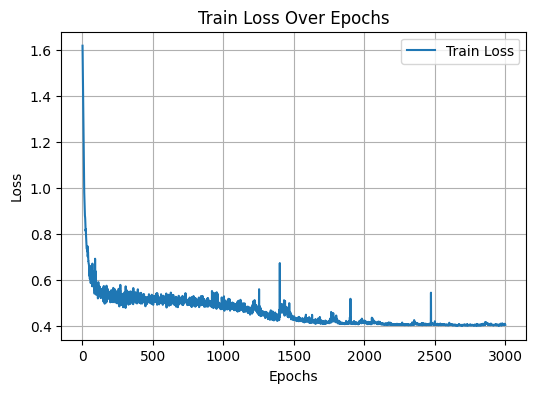

In [17]:
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

train_losses = []
for epoch in range(1,3000):
    pred = model(G, nfeats, efeats).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    train_losses.append(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

train_losses =  [tensor.cpu().detach().numpy() for tensor in train_losses]
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

epochs = range(1, 3000)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

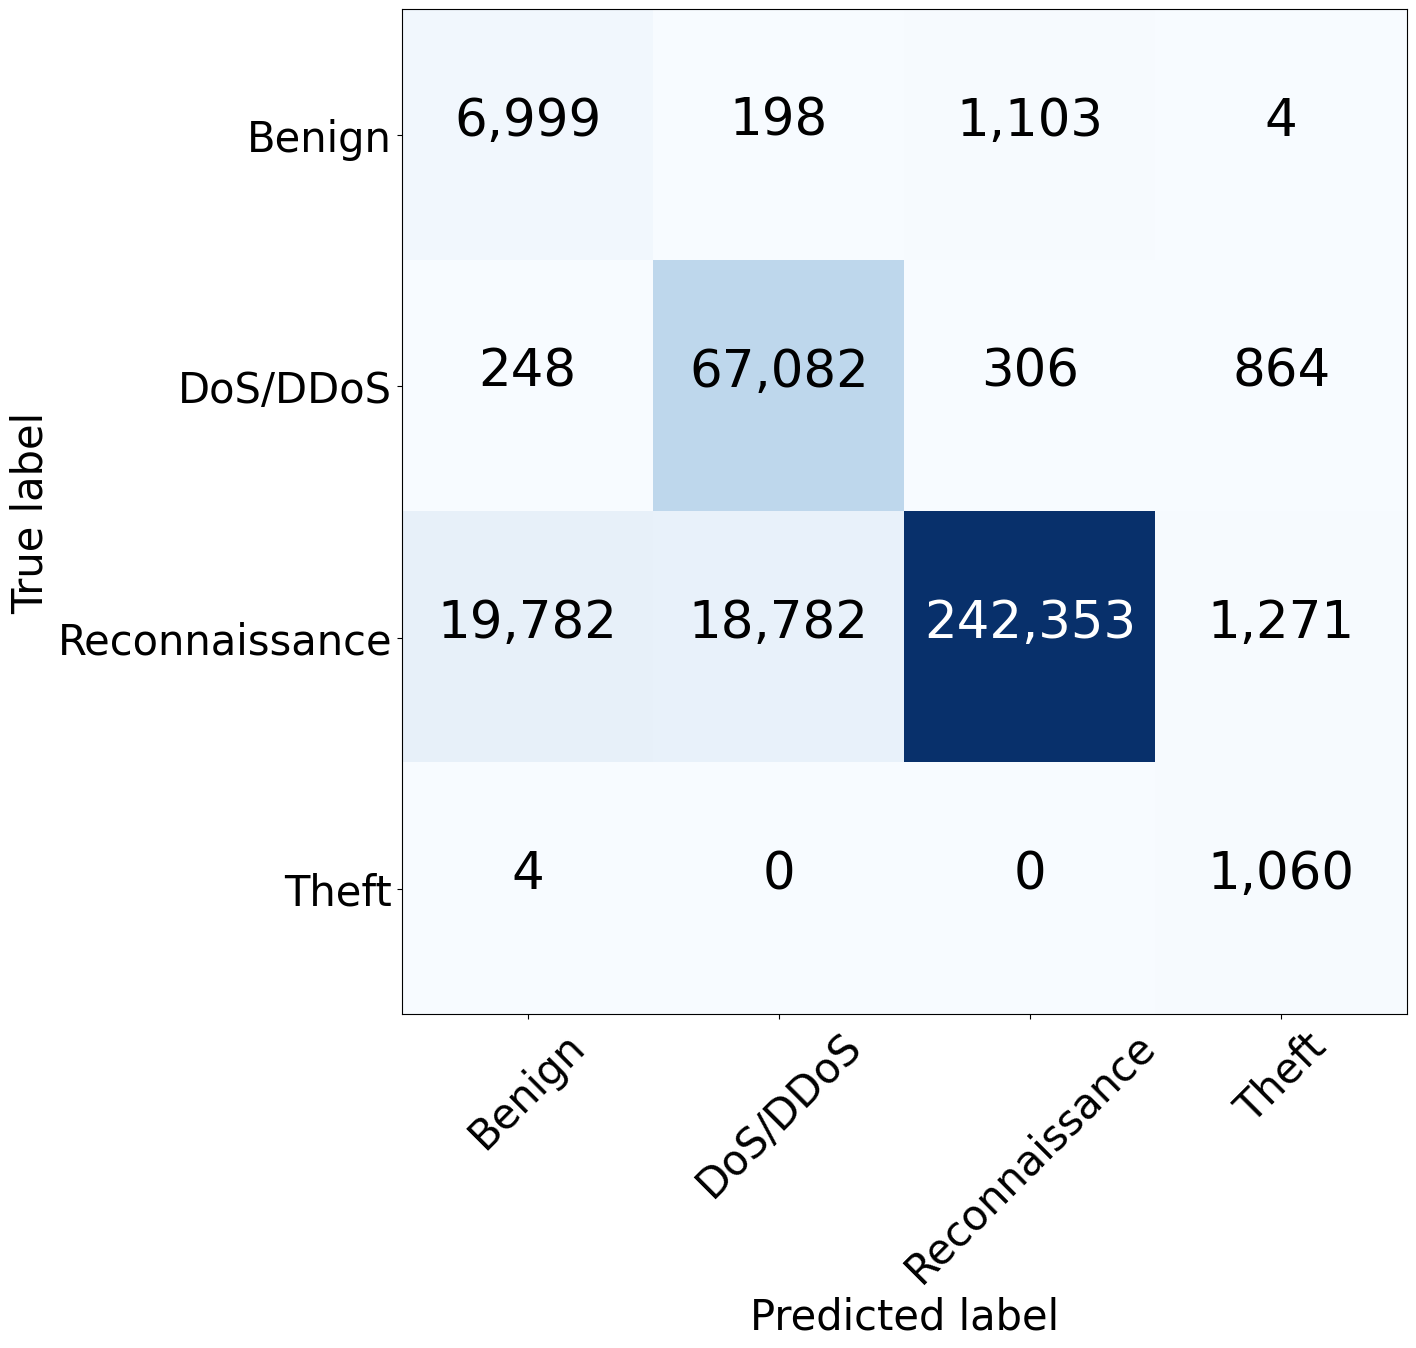

In [10]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=30,
                          text_fontsize=37):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      # title        = "Confusion Matrix"
                      )

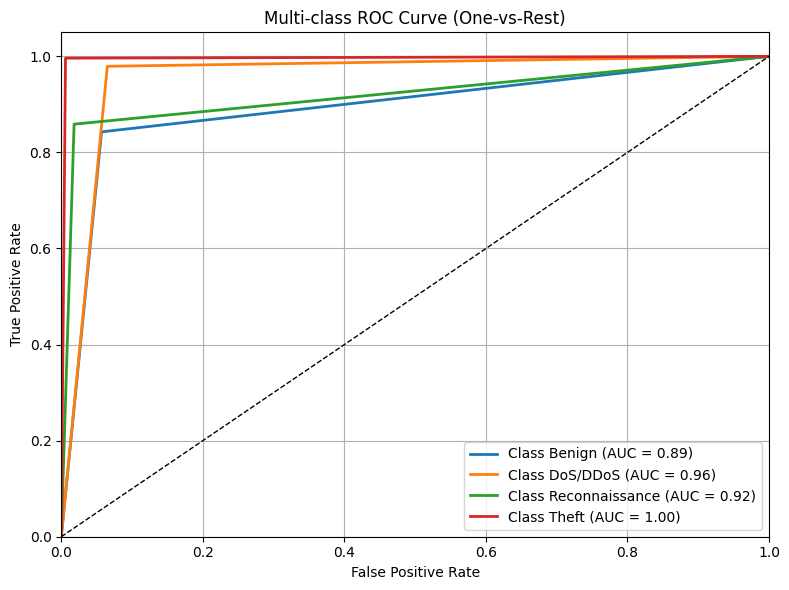

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load example dataset
X = actual
y = test_pred
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Save Model

In [52]:
th.save(model, "/scratch/kc01/na3038/TrainedModels/model_state.pth")

In [9]:
def load_checkpoint(filepath):
  checkpoint = th.load(filepath, map_location='cuda')
  model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)
  model.load_state_dict(checkpoint['state_dict'])
  return model

In [10]:
model = th.load("/scratch/kc01/na3038/TrainedModels/model_state.pth")
print(model)

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=16, out_features=128, bias=True)
        (W_apply): Linear(in_features=136, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=136, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [11]:
model = model.to('cuda')

In [30]:
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

# actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)


# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, test_pred, output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

0.011294623836874962 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.2689    0.8546    0.4091    0.8546    8354      
DoS            0.7825    0.9695    0.8660    0.9695    68468     
Reconnaissance 0.9930    0.8632    0.9236    0.8632    282026    
Theft          0.2551    0.7471    0.3803    0.7471    1202      

Overall Accuracy:
Accuracy: 0.8828

Weighted Averages:
{'precision': 0.9337421989219714, 'recall': 0.8828218303013471, 'f1-score': 0.8988798792901675, 'support': 360050.0}


In [18]:
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)


# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, test_pred, output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

0.014568910002708435 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.2620    0.9973    0.4150    0.9973    8260      
DDoS           0.3601    0.3731    0.3665    0.3731    34264     
DoS            0.4091    0.6003    0.4866    0.6003    34136     
Reconnaissance 0.9971    0.8485    0.9168    0.8485    282182    
Theft          0.1839    0.4384    0.2591    0.4384    1218      

Overall Accuracy:
Accuracy: 0.7818

Weighted Averages:
{'precision': 0.8611295817591849, 'recall': 0.7817613731044826, 'f1-score': 0.8099282026322722, 'support': 360060.0}


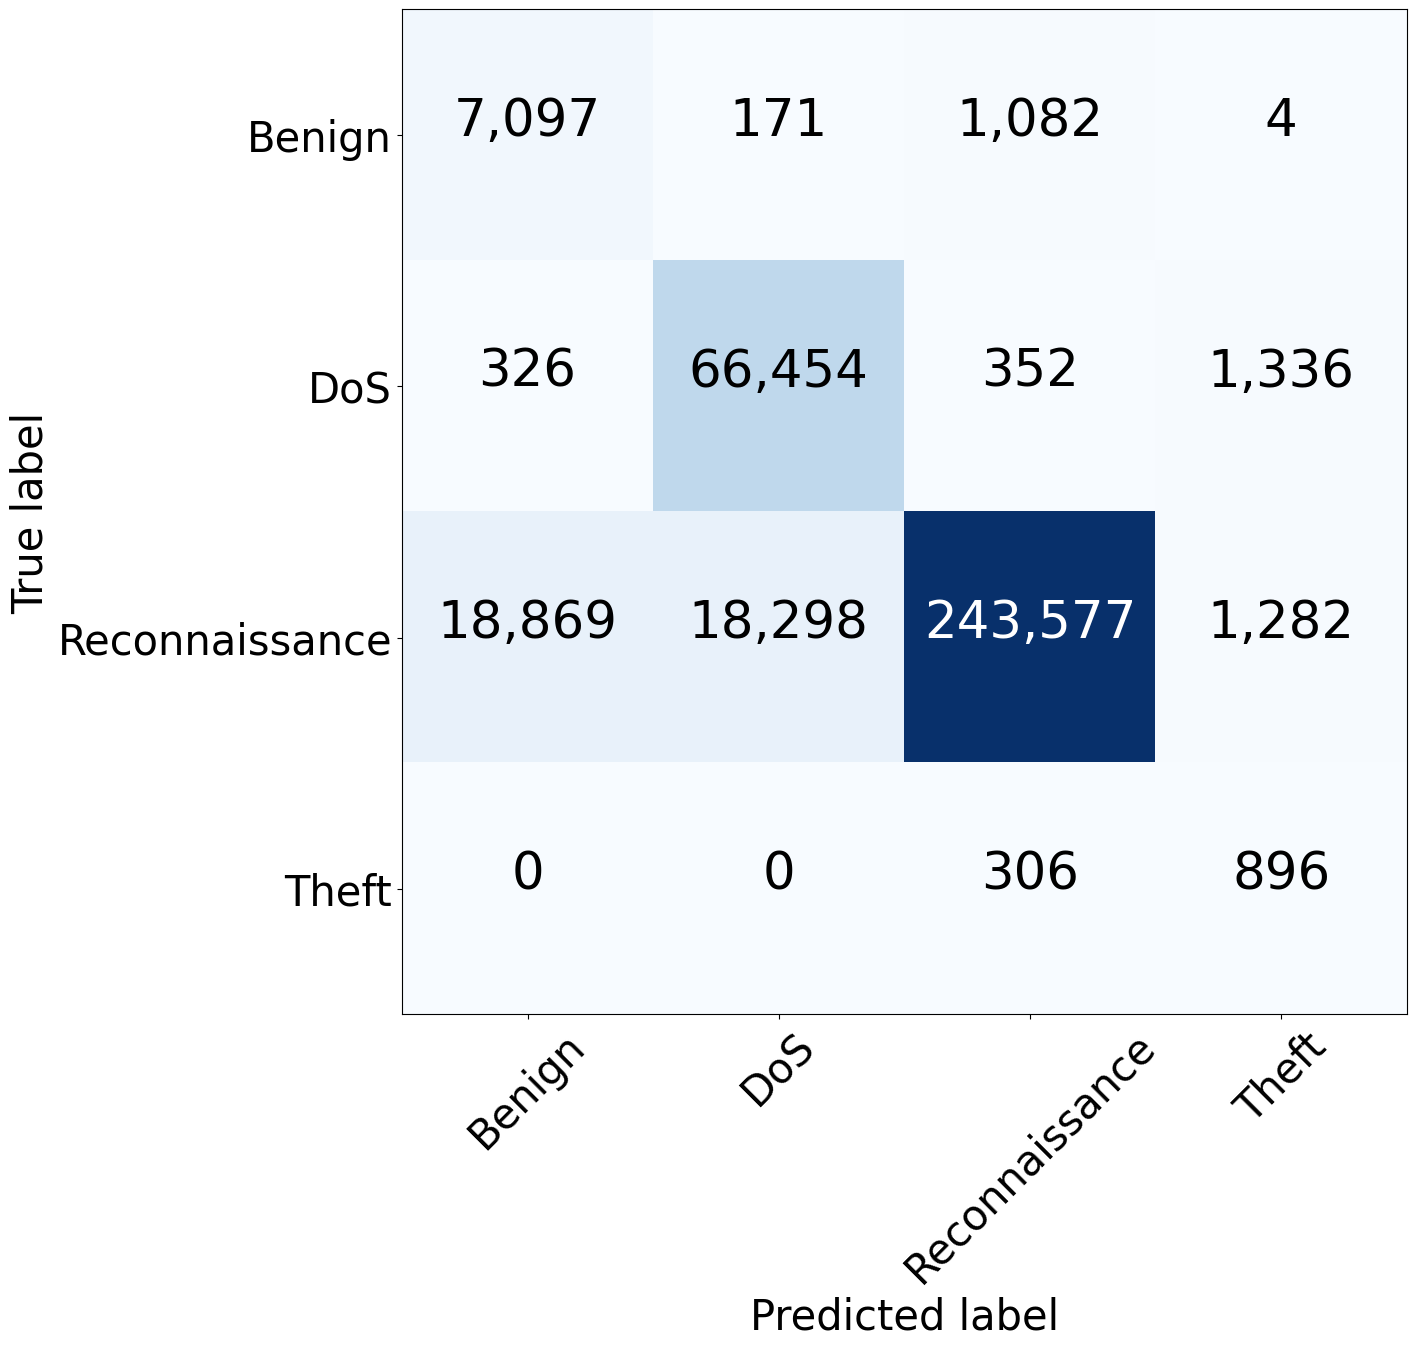

In [57]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=30,
                          text_fontsize=37):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      # title        = "Confusion Matrix"
                      )

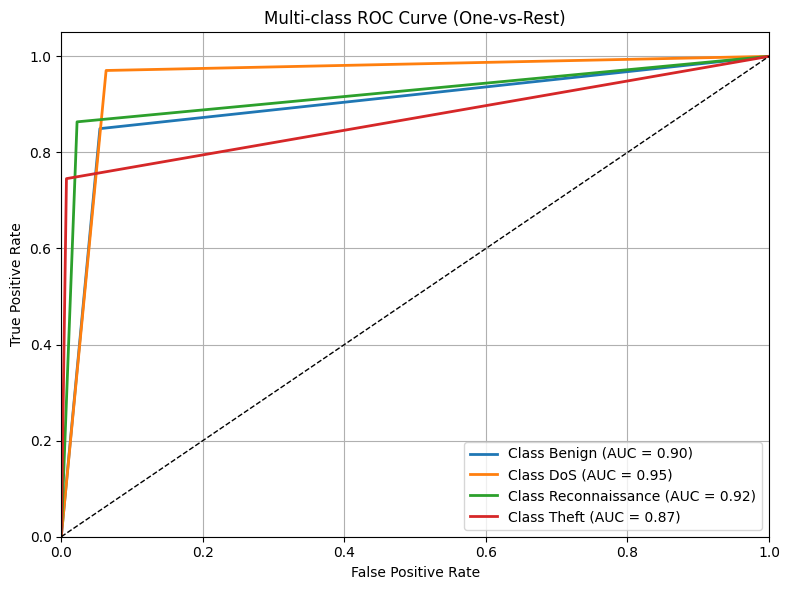

In [58]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load example dataset
X = actual
y = test_pred
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## Save TPs for use in XAI

In [59]:
true_positives = {}
for i in range(len(actual)):
    if test_pred[i] == actual[i]:
      # key = G_test.edata['label'][i].cpu().item()
      key = actual[i]
      if key not in true_positives:
          true_positives[key] = []
      true_positives[key].append(G_test.edata['Edge_indx'][i].cpu().item())

In [12]:
import pickle

file_path = '/scratch/kc01/na3038/TrainedModels/true_positives_sample.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(true_positives, f)
# print(f"True positives saved to {file_path}")

In [13]:
with open(file_path, 'rb') as f:
    true_positives = pickle.load(f)

# true_positives

In [54]:
len(true_positives['Reconnaissance'])

243577

In [66]:
min_count,e

(2, 3007)

In [88]:
min_count=20000
e=0
edges_to_explain=random.sample(true_positives['Reconnaissance'], 5000)#[:5]
for x in edges_to_explain:
    indx_to_explain = (G_test.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0][0].item()
    # print('indx_to_explain',indx_to_explain)
    source_node = th.Tensor.cpu(G_test.edges()[0][int(indx_to_explain)]).detach().numpy()
    # print('source_node',source_node)
    sg, inverse_indices = khop_out_subgraph(G_test, source_node, 2)
    edge_count = sg.num_edges()
    if 25<edge_count<min_count:
        min_count=edge_count
        e=x
print(min_count,e)

76 13325


In [69]:
indx_to_explain = (G_test.edata['Edge_indx'] == 7834).nonzero(as_tuple=True)[0][0].item()
source_node = th.Tensor.cpu(G_test.edges()[0][int(indx_to_explain)]).detach().numpy()
khop_out_subgraph(G_test, source_node, 2)

(Graph(num_nodes=9, num_edges=16,
       ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([7], device='cuda:0'))

# E-PGExplainer

In [103]:
import torch
from math import sqrt
import math
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph, batch
from torch.optim import Adam

import torch.nn as nn

In [104]:
class ExplainerModel(nn.Module):
    def __init__(self):
        super(ExplainerModel, self).__init__()
        self.elayers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )

    def forward(self, x):
        x = self.elayers(x)
        x = x.mean(dim=0)
        return x

In [105]:
def generate_computation_graph(graph,edge_id):
    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    return sg,inverse_indices

def create_explainer_input(pair, embeds):
        rows = pair[0]
        cols = pair[1]
        row_embeds = embeds[rows]
        col_embeds = embeds[cols]
        input_expl = th.cat([row_embeds, col_embeds], 1)
        return input_expl

In [19]:
#Updated Version
class PGExplainer(nn.Module):
    def __init__(self,model,num_hops=None,explain_graph=True,coff_budget=0.01, coff_connect=5e-4,sample_bias=0.0,):
      super(PGExplainer, self).__init__()
      self.elayers  = ExplainerModel()
      self.model = model
      self.graph_explanation = explain_graph
      self.num_hops = num_hops

      # training hyperparameters for PGExplainer
      self.coff_budget = coff_budget
      self.coff_connect = coff_connect
      self.sample_bias = sample_bias
      self.init_bias = 0.0

    def set_masks(self, graph, edge_mask=None):
        if edge_mask is None:
            num_nodes = graph.num_nodes()
            num_edges = graph.num_edges()

            init_bias = self.init_bias
            std = nn.init.calculate_gain("relu") * math.sqrt(
                2.0 / (2 * num_nodes)
            )
            self.edge_mask = torch.randn(num_edges) * std + init_bias
        else:
            self.edge_mask = edge_mask

        self.edge_mask = self.edge_mask.to(graph.device)

    def clear_masks(self):
        self.edge_mask = None
    def concrete_sample(self, w, beta=1.0, training=True):
          if training:
              bias = self.sample_bias
              random_noise = torch.rand(w.size()).to(w.device)
              random_noise = bias + (1 - 2 * bias) * random_noise
              gate_inputs = torch.log(random_noise) - torch.log(
                  1.0 - random_noise
              )
              gate_inputs = (gate_inputs + w) / beta
              gate_inputs = torch.sigmoid(gate_inputs)
          else:
              gate_inputs = torch.sigmoid(w)

          return gate_inputs

    def loss(self, prob, ori_pred):
        target_prob = prob.gather(-1, ori_pred.unsqueeze(-1))
        # 1e-6 added to prob to avoid taking the logarithm of zero
        target_prob += 1e-6
        # computing the log likelihood for a single prediction
        pred_loss = torch.mean(-torch.log(target_prob))

        # size
        edge_mask = self.sparse_mask_values
        if self.coff_budget <= 0:
            size_loss = self.coff_budget * torch.sum(edge_mask)
        else:
            size_loss = self.coff_budget * F.relu(
                torch.sum(edge_mask) - self.coff_budget
            )

        # entropy
        scale = 0.99
        edge_mask = self.edge_mask * (2 * scale - 1.0) + (1.0 - scale)
        mask_ent = -edge_mask * torch.log(edge_mask) - (
            1 - edge_mask
        ) * torch.log(1 - edge_mask)
        mask_ent_loss = self.coff_connect * torch.mean(mask_ent)

        loss = pred_loss + size_loss + mask_ent_loss
        return loss

    def train_step_node(self, edges, graph, temperature, **kwargs):
          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          prob, _, batched_graph, inverse_indices = self.explain_node(
              edges, graph, temperature, training=True, **kwargs
          )

          pred = self.model(
              batched_graph, self.batched_feats,self.batched_efeats, **kwargs
          )
          pred = pred.argmax(-1).data

          loss = self.loss(prob[inverse_indices], pred[inverse_indices])

          del batched_graph,_, inverse_indices,prob, pred

          torch.cuda.empty_cache()

          return loss

    def explain_node(self, edges, graph, temperature=1.0, training=False, **kwargs):
          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if training:
              self.elayers.train()
          else:
              self.elayers.eval()

          self.model.eval()

          batched_graph = []
          batched_embed = []
          for edge_id in edges:
              sg, inverse_indices =  generate_computation_graph(graph, edge_id)
              sg.ndata["feat"]= features[sg.ndata[NID].long()]
              sg.edata["feat"]= edge_features[sg.edata[EID].long()]
              # feats = features[sg.ndata[NID].long()]
              # efeats = edge_features[sg.edata[EID].long()]
              sg.edata["train"] = torch.tensor(
                [eid in inverse_indices for eid in sg.edges(form='eid')], device=sg.device
              )

              embed = self.model(sg, sg.ndata["feat"],sg.edata["feat"],embed=True)
              embed = embed.data

              # col, row = sg.edges()
              # col_emb = embed[col.long()]
              # row_emb = embed[row.long()]
              # self_emb = embed[inverse_indices[0]].repeat(sg.num_edges(), 1)
              # need to concat these if considering combine node-based edge embeddings with raw edge features
              # emb = create_explainer_input(sg.edges(), embeds) # i think not needed because we do not consider on node embeddings
              batched_embed.append(embed)
              batched_graph.append(sg)
              # print("train step edge:",edge_id)

          batched_graph = batch(batched_graph)

          batched_embed = torch.cat(batched_embed)
          batched_embed = self.elayers(batched_embed) #1,8
          values = batched_embed.reshape(-1) # 8
          values = self.concrete_sample(
              values, beta=temperature, training=training
          )
          self.sparse_mask_values = values

          # col, row = batched_graph.edges()
          # reverse_eids = batched_graph.edge_ids(row, col).long()
          # edge_mask = (values + values[reverse_eids]) / 2
          # todo
          edge_mask = values

          self.set_masks(batched_graph, edge_mask)

          batched_feats = batched_graph.ndata['feat']
          batched_efeats = batched_graph.edata['h']
          # the model prediction with the updated edge mask
          logits = self.model(
              batched_graph, batched_feats, batched_efeats, feature_weight=self.edge_mask, **kwargs
          )
          probs = F.softmax(logits, dim=-1)
          # print(probs.shape)

          batched_inverse_indices = (
              batched_graph.edata["train"].nonzero().squeeze(1)
          )

          if training:
              self.batched_feats = batched_feats
              self.batched_efeats = batched_efeats
              probs = probs.data
          else:
              self.clear_masks()

          del batched_feats, batched_efeats, logits
          torch.cuda.empty_cache()
          return (
              probs,
              edge_mask,
              batched_graph,
              batched_inverse_indices,
          )

In [20]:
features = G_test.ndata['feature']
edge_features = G_test.edata['h']
labels = G_test.edata['label']

In [71]:
final_features ={key: [] for key in range(4)} 
for attack in true_positives.keys():
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
    print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],50)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)

---------- Reconnaissance ----------
0.6287718415260315
OUT_PKTS: 3.688266474455304e-07
OUT_BYTES: 2.0719909343824838e-07
PROTOCOL: 1.604060315685274e-07
IN_PKTS: 4.558545896315991e-08
FLOW_DURATION_MILLISECONDS: 3.075654220197066e-08
L7_PROTO: 5.963372462503003e-09
IN_BYTES: 8.10827127661895e-10
TCP_FLAGS: 2.2997063975349619e-10
---------- DoS ----------
0.6290888786315918
OUT_BYTES: 4.578065272653475e-06
OUT_PKTS: 2.8130709779361496e-06
PROTOCOL: 7.73023245415061e-08
IN_BYTES: 1.924790815621691e-08
FLOW_DURATION_MILLISECONDS: 1.671467764197132e-08
TCP_FLAGS: 1.6463891583384793e-08
IN_PKTS: 1.2060435317096108e-08
L7_PROTO: 7.52913620338802e-10
---------- Benign ----------
0.7331382632255554
OUT_BYTES: 2.691496047191322e-05
FLOW_DURATION_MILLISECONDS: 5.695277195627568e-06
PROTOCOL: 5.539079211303033e-06
TCP_FLAGS: 1.8539703887654468e-06
IN_PKTS: 1.3461173011819483e-06
L7_PROTO: 7.62279853461223e-07
IN_BYTES: 6.231036309145566e-07
OUT_PKTS: 5.872925967764786e-08
---------- Theft ------

In [ ]:
# ---------- Reconnaissance ----------
# /tmp/ipython-input-17-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.2868693470954895
# ========================================================
# ---------- Benign ----------
# /tmp/ipython-input-17-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.290720671415329
# ========================================================
# ---------- DoS ----------
# /tmp/ipython-input-17-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.2925584316253662
# ========================================================
# ---------- Theft ----------
# /tmp/ipython-input-17-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.2858952581882477
# ========================================================
# {0: [3, 1, 0, 4, 6, 2, 5, 7], 1: [5, 7, 0, 3, 1, 4, 6, 2], 2: [1, 4, 7, 0, 3, 5, 6, 2], 3: [7, 0, 1, 6, 3, 2, 5, 4]}

Codes for Single class Explain

In [ ]:
selected_indices = []

for class_label in range(0,1):
    class_indices = torch.nonzero(labels == class_label, as_tuple=False).squeeze()[:10]
    selected_indices.extend(class_indices)
len(selected_indices)

10

In [ ]:
# torch.cuda.empty_cache()
explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
explainer = explainer.to('cuda')

init_tmp, final_tmp = 5.0, 1.0
optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
epochs = 5
train_losses = []
for epoch in range(epochs):
    # selected_indices = torch.randperm(G.edges(form='eid').size(0), device='cuda:0')[:10]  # Get random indices
    # random_edges = G.edges(form='eid')[selected_indices]  # Use the indices to select from the tensor

    tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
    loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
    train_losses.append(loss.item())
    optimizer_exp.zero_grad()
    loss.backward()
    optimizer_exp.step()
    print(epoch, loss)

/tmp/ipython-input-8-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0 tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)
1 tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>)
2 tensor(0.1731, device='cuda:0', grad_fn=<AddBackward0>)
3 tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)
4 tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


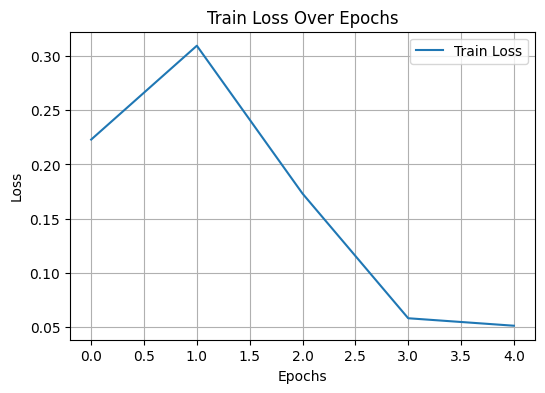

In [ ]:
epochs = range(0, len(train_losses))
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
# 10 edges, 10 epoches

In [ ]:
le.transform(['Benign'])

array([0])

In [ ]:
edges_to_explain = random.sample(true_positives['Benign'],10)
probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
edge_weight = edge_weight.cpu().detach().numpy()

feature_importance = {}
for k in range(8):
  feature_importance[cols_to_norm[k]]=edge_weight[k]
sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_items:
  print(f'{key}: {value}') #display importance scores

IN_BYTES: 1.6484761999890907e-07
TCP_FLAGS: 8.109129367994683e-08
L7_PROTO: 4.834532418840354e-08
FLOW_DURATION_MILLISECONDS: 3.0628456215708866e-08
OUT_PKTS: 8.550905761239846e-09
PROTOCOL: 1.6526775503677982e-09
OUT_BYTES: 1.1996191817686963e-09
IN_PKTS: 8.994483630120342e-11


/tmp/ipython-input-8-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


### reconssiance attack - class-wise

In [20]:
final_features ={key: [] for key in range(4)}
for attack in ["Reconnaissance"]:
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
    print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],50)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)

---------- Reconnaissance ----------


/jobfs/144524378.gadi-pbs/ipykernel_433063/1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.6288153529167175
OUT_PKTS: 0.0009376817033626139
PROTOCOL: 1.2095013516955078e-05
FLOW_DURATION_MILLISECONDS: 7.628321327501908e-06
IN_PKTS: 6.226941422937671e-06
OUT_BYTES: 5.346730176825076e-06
IN_BYTES: 6.318016971817997e-07
L7_PROTO: 2.525881086512527e-07
TCP_FLAGS: 2.3406292015692998e-08
{0: [], 1: [], 2: [0, 5, 4, 1, 7, 2, 3, 6], 3: []}


In [ ]:
# [1, 4, 7, 0, 3, 5, 6, 2]
# ---------- Reconnaissance ----------
# /tmp/ipython-input-10-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.05111732333898544
# IN_BYTES: 9.197347772271769e-09
# TCP_FLAGS: 9.115736609999203e-09
# FLOW_DURATION_MILLISECONDS: 5.6124225267240035e-09
# OUT_PKTS: 4.263878583543601e-09
# PROTOCOL: 2.531512555137283e-09
# OUT_BYTES: 8.468563073016355e-10
# IN_PKTS: 1.1178071662731881e-10
# L7_PROTO: 1.5892932803129867e-11
# ========================================================
# {0: [], 1: [], 2: [0, 5, 1, 3, 7, 6, 2, 4], 3: []}

#### for single edge

In [22]:
for attack in ["Reconnaissance"]:
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
    print(loss.item())

    #explain with trained model
    edges_to_explain = 3804 #random.sample(true_positives[attack],1)
    print("edges_to_explain: ",edges_to_explain)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      # final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
# print(final_features)

---------- Reconnaissance ----------


/jobfs/144524378.gadi-pbs/ipykernel_433063/1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.6271741986274719
edges_to_explain:  3804
L7_PROTO: 0.0002485595177859068
OUT_BYTES: 1.9505878299241886e-05
IN_BYTES: 2.4226967525464715e-06
PROTOCOL: 2.185087168982136e-06
FLOW_DURATION_MILLISECONDS: 1.5648728322048555e-06
OUT_PKTS: 7.032364237602451e-07
IN_PKTS: 3.9389013295476616e-07
TCP_FLAGS: 6.629142035308178e-08


In [21]:
# 0.4215536415576935
# edges_to_explain:  0
# TCP_FLAGS: 0.03563801944255829
# IN_BYTES: 0.00905900914222002
# OUT_PKTS: 0.006902334280312061
# OUT_BYTES: 0.004943086300045252
# FLOW_DURATION_MILLISECONDS: 0.004238730296492577
# PROTOCOL: 0.002167114522308111
# IN_PKTS: 0.002084325300529599
# L7_PROTO: 0.0018014857778325677
# ========================================================

In [202]:
class ExplainerModel(nn.Module):
    def __init__(self):
        super(ExplainerModel, self).__init__()
        self.elayers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.elayers(x)
        # x = x.mean(dim=0)
        return x

In [201]:
#Updated Version
class PGExplainer(nn.Module):
    def __init__(self,model,num_hops=None,explain_graph=True,coff_budget=0.01, coff_connect=5e-4,sample_bias=0.0,):
      super(PGExplainer, self).__init__()
      self.elayers  = ExplainerModel()
      self.model = model
      self.graph_explanation = explain_graph
      self.num_hops = num_hops

      # training hyperparameters for PGExplainer
      self.coff_budget = coff_budget
      self.coff_connect = coff_connect
      self.sample_bias = sample_bias
      self.init_bias = 0.0

    def set_masks(self, graph, edge_mask=None):
        if edge_mask is None:
            num_nodes = graph.num_nodes()
            num_edges = graph.num_edges()

            init_bias = self.init_bias
            std = nn.init.calculate_gain("relu") * math.sqrt(
                2.0 / (2 * num_nodes)
            )
            self.edge_mask = torch.randn(num_edges) * std + init_bias
        else:
            self.edge_mask = edge_mask

        self.edge_mask = self.edge_mask.to(graph.device)

    def clear_masks(self):
        self.edge_mask = None
    def concrete_sample(self, w, beta=1.0, training=True):
          if training:
              bias = self.sample_bias
              random_noise = torch.rand(w.size()).to(w.device)
              random_noise = bias + (1 - 2 * bias) * random_noise
              gate_inputs = torch.log(random_noise) - torch.log(
                  1.0 - random_noise
              )
              gate_inputs = (gate_inputs + w) / beta
              gate_inputs = torch.sigmoid(gate_inputs)
          else:
              gate_inputs = torch.sigmoid(w)

          return gate_inputs

    def loss(self, prob, ori_pred):
        target_prob = prob.gather(-1, ori_pred.unsqueeze(-1))
        # 1e-6 added to prob to avoid taking the logarithm of zero
        target_prob += 1e-6
        # computing the log likelihood for a single prediction
        pred_loss = torch.mean(-torch.log(target_prob))

        # size
        edge_mask = self.sparse_mask_values
        if self.coff_budget <= 0:
            size_loss = self.coff_budget * torch.sum(edge_mask)
        else:
            size_loss = self.coff_budget * F.relu(
                torch.sum(edge_mask) - self.coff_budget
            )

        # entropy
        scale = 0.99
        edge_mask = self.edge_mask * (2 * scale - 1.0) + (1.0 - scale)
        mask_ent = -edge_mask * torch.log(edge_mask) - (
            1 - edge_mask
        ) * torch.log(1 - edge_mask)
        mask_ent_loss = self.coff_connect * torch.mean(mask_ent)

        loss = pred_loss + size_loss + mask_ent_loss
        return loss

    def train_step_node(self, edges, graph, temperature, **kwargs):
          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          prob, _, batched_graph, inverse_indices = self.explain_node(
              edges, graph, temperature, training=True, **kwargs
          )

          pred = self.model(
              batched_graph, self.batched_feats,self.batched_efeats, **kwargs
          )
          pred = pred.argmax(-1).data

          loss = self.loss(prob[inverse_indices], pred[inverse_indices])

          del batched_graph,_, inverse_indices,prob, pred

          torch.cuda.empty_cache()

          return loss

    def explain_node(self, edges, graph, temperature=1.0, training=False, **kwargs):
          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if training:
              self.elayers.train()
          else:
              self.elayers.eval()

          self.model.eval()

          batched_graph = []
          batched_embed = []
          for edge_id in edges:
              sg, inverse_indices =  generate_computation_graph(graph, edge_id)
              sg.ndata["feat"]= features[sg.ndata[NID].long()]
              sg.edata["feat"]= edge_features[sg.edata[EID].long()]
              # feats = features[sg.ndata[NID].long()]
              # efeats = edge_features[sg.edata[EID].long()]
              sg.edata["train"] = torch.tensor(
                [eid in inverse_indices for eid in sg.edges(form='eid')], device=sg.device
              )
              embed = self.model(sg, sg.ndata["feat"],sg.edata["feat"],embed=True)
              embed = embed.data

              # col, row = sg.edges()
              # col_emb = embed[col.long()]
              # row_emb = embed[row.long()]
              # self_emb = embed[inverse_indices[0]].repeat(sg.num_edges(), 1)
              # need to concat these if considering combine node-based edge embeddings with raw edge features
              emb = create_explainer_input(sg.edges(), embed) # i think not needed because we do not consider on node embeddings
              batched_embed.append(emb)
              batched_graph.append(sg)
              # print("train step edge:",edge_id)

          batched_graph = batch(batched_graph)

          batched_embed = torch.cat(batched_embed)
          batched_embed = self.elayers(batched_embed) #1,1
          values = batched_embed.reshape(-1) # 1
          values = self.concrete_sample(
              values, beta=temperature, training=training
          )
          self.sparse_mask_values = values

          # col, row = batched_graph.edges()
          # reverse_eids = batched_graph.edge_ids(row, col).long()
          # edge_mask = (values + values[reverse_eids]) / 2
          # todo
          edge_mask = values

          self.set_masks(batched_graph, edge_mask)

          batched_feats = batched_graph.ndata['feat']
          batched_efeats = batched_graph.edata['h']
          # the model prediction with the updated edge mask
          logits = self.model(
              batched_graph, batched_feats, batched_efeats, edge_weight=self.edge_mask, **kwargs
          )
          probs = F.softmax(logits, dim=-1)
          # print(probs.shape)

          # batched_inverse_indices = (
          #     batched_graph.edata["train"].nonzero().squeeze(1)
          # )

          if training:
              self.batched_feats = batched_feats
              self.batched_efeats = batched_efeats
              probs = probs.data
          else:
              self.clear_masks()

          if training:
            batched_inverse_indices = (
                batched_graph.edata["train"].nonzero().squeeze(1)
            )
          else:
            for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
              if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                      edge_indice = indx
                      break
            batched_inverse_indices= edge_indice
            batched_graph = sg

          del batched_feats, batched_efeats, logits
          torch.cuda.empty_cache()
          return (
              probs,
              edge_mask,
              batched_graph,
              batched_inverse_indices,
          )

In [203]:
features = G_test.ndata['feature']
edge_features = G_test.edata['h']
labels = G_test.edata['label']
explainer = PGExplainer(
            model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
        )
explainer = explainer.to('cuda')

In [204]:
def explain_edges(explainer):
    for attack in ["Reconnaissance"]:
        print ("----------", attack,"----------")
        attack_id = le.transform([attack])[0]
        class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
        selected_indices = class_indices[torch.randperm(class_indices.size(0))][:5] # select 50 random edges from train data for each attack        
    
        torch.cuda.empty_cache()
        init_tmp, final_tmp = 5.0, 0.5
        optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
        epochs = 3
        train_losses = []
        for epoch in range(epochs):
            # tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
            tmp = init_tmp * ((final_tmp / init_tmp) ** (epoch / epochs))
            loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
            train_losses.append(loss.item())
            optimizer_exp.zero_grad()
            loss.backward()
            optimizer_exp.step()
            print(loss.item())
        # epochs = range(0, 5)
        # plt.figure(figsize=(6, 4))
        # plt.plot(epochs, train_losses, label='Train Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title('Train Loss Over Epochs')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
    
        #explain with trained model
        # edges_to_explain =7834  #random.sample(true_positives[attack],1)
        edges_to_explain = int(list((G_test.edata['Edge_indx'] == 13325 ).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0])#7834
        print("edges_to_explain: ",edges_to_explain)
        probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
        del explainer, train_losses
        torch.cuda.empty_cache()
        print('========================================================')
    # print(final_features)
    return probs, edge_weight, bg, inverse_indices

In [205]:
probs, edge_weight, bg, inverse_indices = explain_edges(explainer)

---------- Reconnaissance ----------
786.6998291015625
311.9076843261719
2.8873345851898193
edges_to_explain:  287932


In [206]:
bg

Graph(num_nodes=39, num_edges=76,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1, 8), dtype=torch.float32), 'train': Scheme(shape=(), dtype=torch.bool)})

In [207]:
edge_weight_mul=edge_weight*100000000
edge_weight_mul

tensor([19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863,
        19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863,
        19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863,
        19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863,
        19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9863, 19.9864,
        19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864,
        19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864,
        19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864, 19.9864,
        19.9864, 19.9864, 19.9863, 19.9864, 19.9864, 19.9863, 19.9864, 19.9864,
        19.9864, 19.9864, 19.9864, 19.9864], device='cuda:0',
       grad_fn=<MulBackward0>)

In [208]:
edge_mask_intrusion_round = th.round(attck_edge_mask)
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
# unwanted_1 = list((edge_weight_mul < 0.55).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if inverse_indices in unwanted_1:
    unwanted_1.remove(inverse_indices)

print(len(unwanted_1))

36


In [209]:
import dgl
g_intrusion = dgl.remove_edges(bg, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], int(x[1])])] = valuess[indx].item() #le.inverse_transform([valuess[indx]]).item() #valuess[indx].item()

nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == bg.edata["Edge_indx"][inverse_indices].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])

{(0, 5): Text(0.7342042032659765, 0.44175604026131116, '167447'),
 (1, 9): Text(0.3032412240813963, 0.5719735773612058, '162613'),
 (2, 11): Text(0.09078997502056046, 0.5537942948408505, '61162'),
 (2, 15): Text(-0.043281255678358055, 0.1558850192156928, '172938'),
 (3, 8): Text(0.31715557075668105, 0.7960003613454509, '2373'),
 (3, 13): Text(-0.07578003254512516, 0.46223785020608626, '27700'),
 (3, 21): Text(0.3171556005590034, -0.19082617629973436, '34273'),
 (3, 20): Text(0.21297755948649996, -0.1619012939286496, '36815'),
 (3, 12): Text(-0.030382005904486198, 0.5603640677903226, '43496'),
 (3, 19): Text(0.11745295053258248, -0.1112573432994517, '68362'),
 (3, 18): Text(0.035048784188985715, -0.0412625957596548, '73120'),
 (3, 28): Text(0.8863568009551839, 0.19510178343153722, '80986'),
 (3, 24): Text(0.632250667137992, -0.13916897651310894, '85968'),
 (3, 6): Text(0.5318107611596175, 0.784362077632343, '106747'),
 (3, 14): Text(-0.09902241670761047, 0.3566466500631805, '118824'),
 

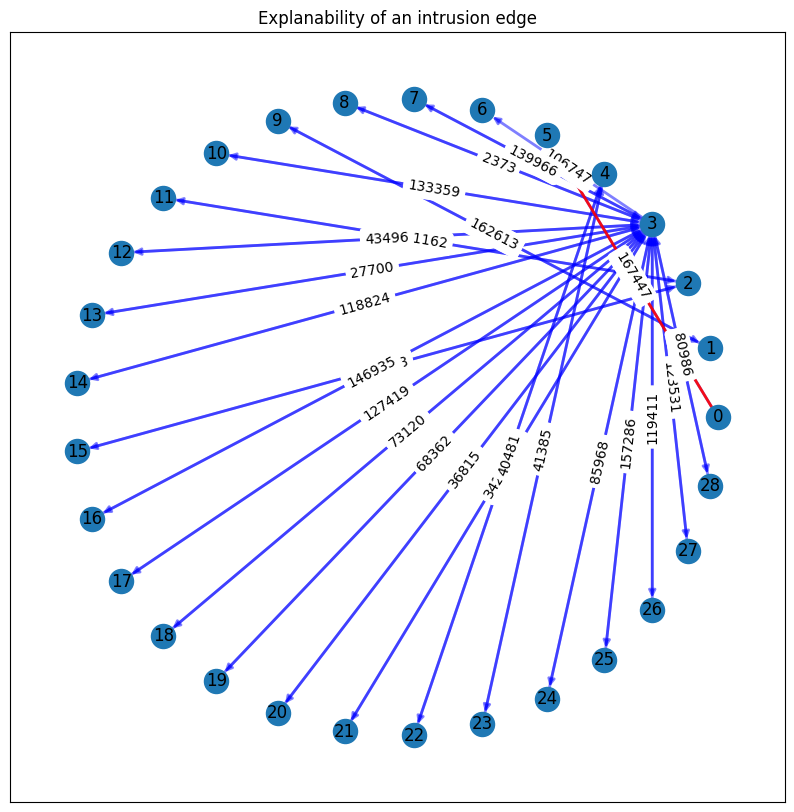

In [78]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[10,10])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

{(0, 28): Text(0.9883102476762013, -0.10748530806365475, '15139'),
 (1, 28): Text(0.9766205251547249, -8.837930075278333e-08, '157704'),
 (2, 28): Text(0.9420979619844363, 0.10245923786237171, '13325'),
 (3, 28): Text(0.8863568009551839, 0.19510178343153722, '23758'),
 (4, 28): Text(0.8120034041677007, 0.27359570626945934, '43166'),
 (5, 28): Text(0.7225144509421778, 0.3342707311699901, '101729'),
 (6, 28): Text(0.6220744555568362, 0.37428967704583, '120302'),
 (9, 28): Text(0.303241194279074, 0.3570030485855308, '103092'),
 (11, 28): Text(0.12531250838852676, 0.23636443982350297, '152582'),
 (12, 28): Text(0.05988168849273251, 0.1502916672038096, '72530'),
 (13, 28): Text(0.014483661852093543, 0.052165449619573256, '47852'),
 (16, 28): Text(0.014483661852093543, -0.26713603594456037, '132543'),
 (18, 28): Text(0.12531247858620442, -0.4513349963461678, '106568'),
 (19, 28): Text(0.2077166449298012, -0.5213297438859648, '53191'),
 (20, 28): Text(0.3032412538837187, -0.5719736945151626, 

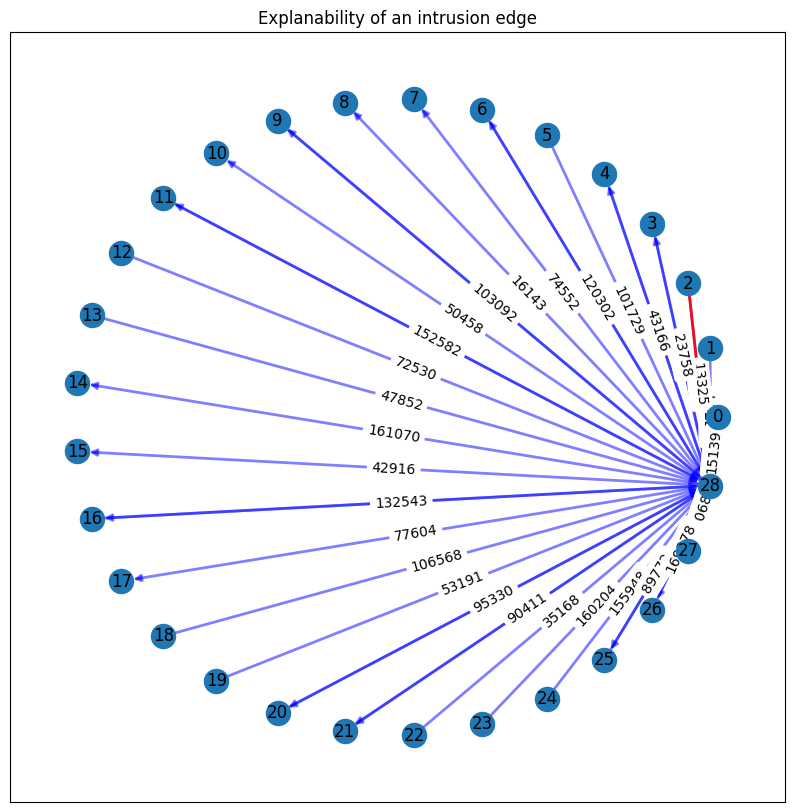

In [210]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[10,10])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

# E-GNNExplainer

In [101]:
from math import sqrt
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph
import dgl
from sklearn.utils import class_weight
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from scipy.stats import linregress

linear_threshold = 0.001  # Threshold for the slope to be considered "linear"
lookback_epochs = 200  # Number of epochs to check for linearity

def init_efeat_masks(graph, efeat):
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()
    device = efeat.device
    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)
    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_edges))
    return efeat_mask


# Regularization loss
def loss_regularize_efeat(loss, feat_mask):
    eps = 1e-15
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    feat_mask = feat_mask.sigmoid()
    loss = loss + beta1 * th.mean(feat_mask)
    ent = -feat_mask * th.log(feat_mask + eps) - (
        1 - feat_mask
    ) * th.log(1 - feat_mask + eps)
    loss = loss + beta2 * ent.mean()
    return loss



# Edge mask
def explain_edge_features(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    sg.edata['label'][-1] = graph.edata['label'][edge_id]
    sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]

    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    efeat_mask = init_efeat_masks(sg, edge_feat)
    params = [efeat_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=250)

    criterion2 = nn.CrossEntropyLoss()
    # criterion2 = nn.BCEWithLogitsLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime

    xai_train_losses = []
    scaler = GradScaler()
    for epoch in range(1, 250):
        optimizer.zero_grad()
        # Apply edge feature mask
        h = edge_feat * efeat_mask.sigmoid()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = h,**kwargs).cuda()
        # predicted_classes= logits[:, edge_label_1, :].squeeze()
        # predicted_classes = th.argmax(logits, dim=1).squeeze()
        loss = criterion2(logits[edge_indice], edge_label_1)
        # loss = loss_regularize(loss11, edge_mask)
        xai_train_losses.append(loss.item())
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if epoch >= lookback_epochs:
          # Calculate the slope of the recent `lookback_epochs` losses
          recent_losses = xai_train_losses[-lookback_epochs:]
          epochs_range = np.arange(lookback_epochs)
          slope, _, _, _, _ = linregress(epochs_range, recent_losses)

          # Check if the slope is below the threshold for linearity
          if abs(slope) < linear_threshold:
              # print(f"Stopping early at epoch {epoch} due to linear loss with slope {slope:.5f}")
              break

        del logits #, predicted_classes
        th.cuda.empty_cache()


    # epochs = range(0, len(xai_train_losses))
    # plt.figure(figsize=(6, 4))
    # # xai_train_losses =  [tensor.cpu().detach().numpy() for tensor in xai_train_losses]
    # plt.plot(epochs, xai_train_losses, label='Train Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.show()
    # efeat_mask = efeat_mask.detach().sigmoid().squeeze()
    del xai_train_losses, epochs_range, slope
    th.cuda.empty_cache()
    return edge_indice, sg, efeat_mask, loss.item()

In [102]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
labels = G_test.edata['label']
final_feature_weights ={key: [] for key in range(4)}

In [80]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
final_features ={key: [] for key in range(4)}

for i in range(0,4):
  attk_class = le.inverse_transform([i])[0]
  print('Class type explaining:', attk_class)
  attack_edge_to_explain = 0 #initialize
  attack_feature_array = {}
  true_predicted_edge_indexes = random.sample(true_positives[attk_class], 50) #50
  for edge_index in true_predicted_edge_indexes:
      attack_indices_list = (G_test.edata['Edge_indx'] == edge_index).nonzero(as_tuple=True)[0].to("cuda").tolist()
      if len(true_predicted_edge_indexes)>0:
        attack_edge_to_explain = attack_indices_list[0]
        attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
        attack_feature_array[edge_index] = (attck_efeat_mask.cpu().detach().tolist())
  lists = list(attack_feature_array.values())
  flat_lists = [item[0] for item in lists]
  averages = [sum(values) / len(values) for values in zip(*flat_lists)]

  feature_importance = {}
  for k in range(8):
    feature_importance[cols_to_norm[k]]=averages[k]

  sorted_items_gnn = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
  for key, value in sorted_items_gnn:
    print(f'{key}: {value}') #display importance scores
    final_features[i].append(cols_to_norm.index(key))

  del true_predicted_edge_indexes, attack_feature_array, lists, averages, feature_importance
  torch.cuda.empty_cache()
  print('========================================================')
# print(sorted_items_gnn)
print(final_features)

Class type explaining: Benign
IN_BYTES: 0.5096440176106989
TCP_FLAGS: 0.5016285622119904
FLOW_DURATION_MILLISECONDS: 0.2696079763397574
IN_PKTS: 0.1523496152460575
PROTOCOL: 0.05049285896122455
OUT_BYTES: -0.2121703615784645
OUT_PKTS: -0.2651218831539154
L7_PROTO: -0.30746547162532806
Class type explaining: DoS
L7_PROTO: 0.8529531425982714
PROTOCOL: 0.8062105301953852
IN_PKTS: 0.6438065309822559
TCP_FLAGS: 0.5713944116234779
OUT_BYTES: 0.43280345857143404
OUT_PKTS: 0.3951264733076096
FLOW_DURATION_MILLISECONDS: -0.22099237650632858
IN_BYTES: -0.42630209743976594
Class type explaining: Reconnaissance
IN_PKTS: 0.8409380620718002
PROTOCOL: 0.8379999566078186
TCP_FLAGS: 0.8236770820617676
OUT_PKTS: 0.8078510749340058
OUT_BYTES: 0.6744910234212875
FLOW_DURATION_MILLISECONDS: 0.5647123933723196
IN_BYTES: 0.5055884365551173
L7_PROTO: 0.3021579933486646
Class type explaining: Theft
PROTOCOL: 0.7256568740217053
L7_PROTO: 0.6177534102177134
OUT_PKTS: 0.11812404953703588
FLOW_DURATION_MILLISECOND

In [ ]:
# Class type explaining: Benign
# ========================================================
# Class type explaining: DoS
# ========================================================
# Class type explaining: Reconnaissance
# ========================================================
# Class type explaining: Theft
# ========================================================
# {0: [5, 0, 4, 1, 6, 3, 7, 2], 1: [7, 4, 5, 3, 1, 2, 0, 6], 2: [6, 3, 4, 2, 7, 5, 0, 1], 3: [3, 6, 4, 2, 1, 7, 5, 0]}

In [25]:
attack_indices_list = (G_test.edata['Edge_indx'] == 3804).nonzero(as_tuple=True)[0].to("cuda").tolist()
# if len(true_predicted_edge_indexes)>0:
attack_edge_to_explain = attack_indices_list[0]
attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
lists = attck_efeat_mask.cpu().detach().tolist()[0]
print(attck_efeat_mask)

feature_importance = {}
for k in range(8):
  feature_importance[cols_to_norm[k]]=lists[k]

sorted_items_gnn = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
for key, value in sorted_items_gnn:
  print(f'{key}: {value}') #display importance scores
# Parameter containing:
# tensor([[ 0.9228,  1.0873,  1.6522, -0.6901,  0.2064,  0.8037,  0.6912,  0.7943]],
#        device='cuda:0', requires_grad=True)
# IN_BYTES: 1.6521923542022705
# IN_PKTS: 1.0873312950134277
# OUT_PKTS: 0.9228017330169678
# PROTOCOL: 0.8036712408065796
# OUT_BYTES: 0.7943319082260132
# TCP_FLAGS: 0.691209614276886
# FLOW_DURATION_MILLISECONDS: 0.20643319189548492
# L7_PROTO: -0.6900508999824524

Parameter containing:
tensor([[0.7187, 0.8607, 1.5575, 0.0794, 0.9467, 1.0053, 0.8470, 0.7949]],
       device='cuda:0', requires_grad=True)
IN_BYTES: 1.5575388669967651
PROTOCOL: 1.0052709579467773
FLOW_DURATION_MILLISECONDS: 0.9466725587844849
IN_PKTS: 0.860664963722229
TCP_FLAGS: 0.847042977809906
OUT_BYTES: 0.7948678731918335
OUT_PKTS: 0.7186578512191772
L7_PROTO: 0.079414501786232


#### Mutual Info

In [45]:
all_tps = [v for values in true_positives.values() for v in values[:1000]]
len(all_tps)

3896

In [163]:
indx_to_explain = []

edges_to_explain= true_positives['Reconnaissance'][:10000]
for x in edges_to_explain:
    indx_to_explain.append((G_test.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0][0].item())

df_indx = pd.DataFrame(columns = ['Edge_indx', 'label'])

for x in indx_to_explain:
    df_indx.loc[-1] = [x, G_test.edata['label'][x].item()]  # adding a row
    df_indx.index = df_indx.index + 1  # shifting index

    
df_indx = df_indx.sort_values('label')
print(df_indx)

# print('nb attacks :', len(df_indx.loc[df_indx['label'] == 1]))
# print('nb benign :', len(df_indx.loc[df_indx['label'] == 0]))
df2_indx = pd.DataFrame(columns = ['Edge_indx', 'label', 'in_out_degrees'])

      Edge_indx  label
9999          0      2
3336      49893      2
3335      49894      2
3334      49895      2
3333      49896      2
...         ...    ...
6665      17773      2
6664      17774      2
6663      17775      2
6670      17768      2
0         53732      2

[10000 rows x 2 columns]


In [363]:
min_count=20000
e=0
for x in df_indx['label'].unique():
    # select the edges having a neighborhood subgraph with 100 <= nb_edges =< 200
    list1 = df_indx.loc[df_indx['label'] == x]['Edge_indx']
    for y in list1:
      source_node = th.Tensor.cpu(G_test.edges()[0][int(y)]).detach().numpy()
      
#       sg, inverse_indices = khop_out_subgraph(G_test, source_node, 2)
#       edge_count = sg.num_edges()
#       if edge_count<min_count:
#           min_count=edge_count
#           e=y
# print(min_count,e)
      if (20 <= edge_count <= 1000) :
        print (edge_count, y)
        df2_indx.loc[-1] = [int(y), x, edge_count]  # adding a row
        df2_indx.index = df2_indx.index + 1  # shifting index
          
      # in_out_degrees = G_test.in_degrees(source_node) + G_test.out_degrees(source_node)
      # # print(in_out_degrees)
      # if (10 >= in_out_degrees.item() <= 100) :
      #   df2_indx.loc[-1] = [int(y), x, in_out_degrees.item()]  # adding a row
      #   df2_indx.index = df2_indx.index + 1  # shifting index

# print(df2_indx)
results_dff = df2_indx.apply(pd.to_numeric)
# min_rows = results_dff[results_dff['in_out_degrees'] == results_dff['in_out_degrees'].min()]
min_rows = results_dff[
    (results_dff['label'] == 2) &
    (results_dff['in_out_degrees'] == results_dff[results_dff['label'] == 2]['in_out_degrees'].min())
]
print(min_rows.head())

      Edge_indx  label  in_out_degrees
4435      53131      2               4
4434      53131      2               4
3990      50814      2               4
1308      14696      2               4
1307      14696      2               4


### Explain edge importance

In [75]:
#init mask
def init_masks(graph, efeat):
  efeat_size= efeat.size()[1]
  num_edges = graph.num_edges()
  num_nodes = graph.num_nodes()
  device = efeat.device
  std=0.1
  std= nn.init.calculate_gain("relu") * sqrt (2.0/ (2 * num_nodes))
  edge_mask = nn.Parameter(th.randn(num_edges, device=device)*std)
  return edge_mask

# Regularization loss
def loss_regularize(loss, edge_mask):
    eps = 1e-15
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    edge_mask = edge_mask.sigmoid()
    loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    ent = -edge_mask * th.log(edge_mask + eps) - (
        1 - edge_mask
    ) * th.log(1 - edge_mask + eps)
    loss = loss + alpha2 * ent.mean()
    return loss


linear_threshold = 0.001  # Threshold for the slope to be considered "linear"
lookback_epochs = 200  # Number of epochs to check for linearity
# Edge mask
def explain_edges(model, edge_id, graph, node_feat, edge_feat,class_idx=None, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_out_subgraph(graph, source_node, num_hops)
    print(sg)

    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]

    edge_label_1 = sg.edata["label"][edge_indice]
    if class_idx !=None:
      edge_label_1 = (edge_label_1 == class_idx)
    # print(edge_label_1)

    # edge_mask
    edge_mask = init_masks(sg, edge_feat)
    params = [edge_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=250)

    # criterion2 = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    # criterion2 = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device='cuda'))
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)

    xai_train_losses = []
    scaler = GradScaler()
    for epoch in range(1, 10):#250
        # optimizer.zero_grad()
        # Edge mask
        # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, edge_weight=edge_mask.sigmoid(),class_idx=class_idx).cuda() #edge_mask.sigmoid()
        logits = model(g = sg, nfeats = node_feat, efeats = edge_feat,edge_weight=edge_mask.sigmoid(),**kwargs).cuda()
        # predicted_classes= logits[:, edge_label_1, :].squeeze()
        # predicted_classes = th.sigmoid(logits)
        # print(predicted_classes[edge_indice],edge_label_1.float().view(-1))
        # loss11 = criterion2(predicted_classes[edge_indice], edge_label_1.float().view(-1))
        loss11 = criterion2(logits[edge_indice], edge_label_1)
        loss = loss_regularize(loss11, edge_mask)
        xai_train_losses.append(loss.item())
        # print(loss.item())
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if epoch >= lookback_epochs:
          # Calculate the slope of the recent `lookback_epochs` losses
          recent_losses = xai_train_losses[-lookback_epochs:]
          epochs_range = np.arange(lookback_epochs)
          slope, _, _, _, _ = linregress(epochs_range, recent_losses)

          # Check if the slope is below the threshold for linearity
          if abs(slope) < linear_threshold:
              print(f"Stopping early at epoch {epoch} due to linear loss with slope {slope:.5f}")
              break

        del logits
        th.cuda.empty_cache()

    epochs = range(0, len(xai_train_losses))
    plt.figure(figsize=(6, 4))
    # xai_train_losses =  [tensor.cpu().detach().numpy() for tensor in xai_train_losses]
    plt.plot(epochs, xai_train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    edge_mask = edge_mask.detach().sigmoid()
    th.cuda.empty_cache()
    return edge_indice, sg, edge_mask, loss.item()

In [89]:
attack_edge_to_explain = list((G_test.edata['Edge_indx'] == 13325).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
attack_edge_to_explain

287932

Graph(num_nodes=39, num_edges=76,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})


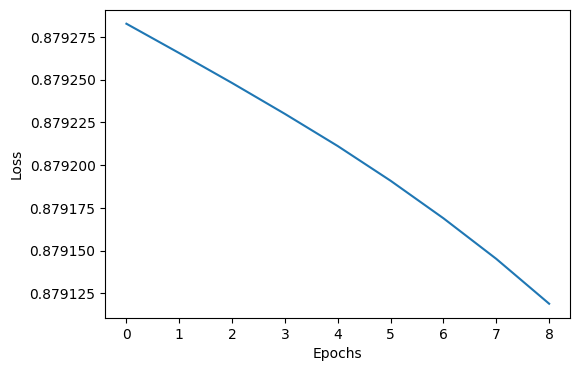

In [92]:
attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model, attack_edge_to_explain, G_test, nfeats, efeats)#,class_idx=1

In [93]:
# len(list((attck_edge_mask < 0.553).nonzero(as_tuple=True)[0].cpu().detach().numpy()))
attck_edge_mask

tensor([0.5301, 0.5041, 0.5773, 0.5331, 0.5628, 0.5209, 0.6177, 0.4609, 0.4832,
        0.5600, 0.3624, 0.4855, 0.4865, 0.6190, 0.5144, 0.4632, 0.4551, 0.4395,
        0.5017, 0.4791, 0.4623, 0.5189, 0.3624, 0.4701, 0.3972, 0.5729, 0.5282,
        0.5135, 0.3772, 0.5494, 0.5394, 0.4566, 0.4455, 0.5788, 0.5331, 0.5876,
        0.5367, 0.5382, 0.4727, 0.6030, 0.5465, 0.5831, 0.3515, 0.4276, 0.5512,
        0.5335, 0.4265, 0.4608, 0.4961, 0.4076, 0.5770, 0.4985, 0.4790, 0.4924,
        0.5339, 0.4338, 0.5756, 0.5039, 0.5636, 0.5110, 0.4256, 0.5234, 0.4850,
        0.4384, 0.4644, 0.6289, 0.5399, 0.5173, 0.4360, 0.4673, 0.5314, 0.4879,
        0.4228, 0.4557, 0.5556, 0.5011], device='cuda:0')

In [377]:
attck_sub_graph.edges()

(tensor([  0,   0,   0,  ..., 473, 473, 473], device='cuda:0'),
 tensor([240, 428, 330,  ..., 147,  27,  90], device='cuda:0'))

In [94]:
print(attck_sub_graph)
edge_mask_intrusion_round = th.round(attck_edge_mask)
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
# unwanted_1 = list((attck_edge_mask < 0.553).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if attck_edge_indice in unwanted_1:
    unwanted_1.remove(attck_edge_indice)

print(len(unwanted_1))

Graph(num_nodes=39, num_edges=76,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
36


In [95]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

In [96]:
g_intrusion

Graph(num_nodes=29, num_edges=40,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [97]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = valuess[indx].item()#le.inverse_transform([valuess[indx]]).item()


nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == attck_sub_graph.edata["Edge_indx"][attck_edge_indice].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])

# u=orange_edge[0]
# v=orange_edge[1]
# for component in nx.weakly_connected_components(nx_graph_intrusion):
#         if u in component and v in component:
#             nodes_to_keep = component
#             break

# G_nx_sub = G_nx_simple.subgraph(nodes_to_keep).copy()


In [390]:
orange_edge

(5, 13)

In [391]:
u=orange_edge[0]
v=orange_edge[1]
for component in nx.weakly_connected_components(nx_graph_intrusion):
    if u in component and v in component:
            nodes_to_keep = component
            break
print(len(nodes_to_keep))
#             break

G_nx_sub = G_nx_simple.subgraph(nodes_to_keep).copy()

2


In [374]:
nx_graph_intrusion

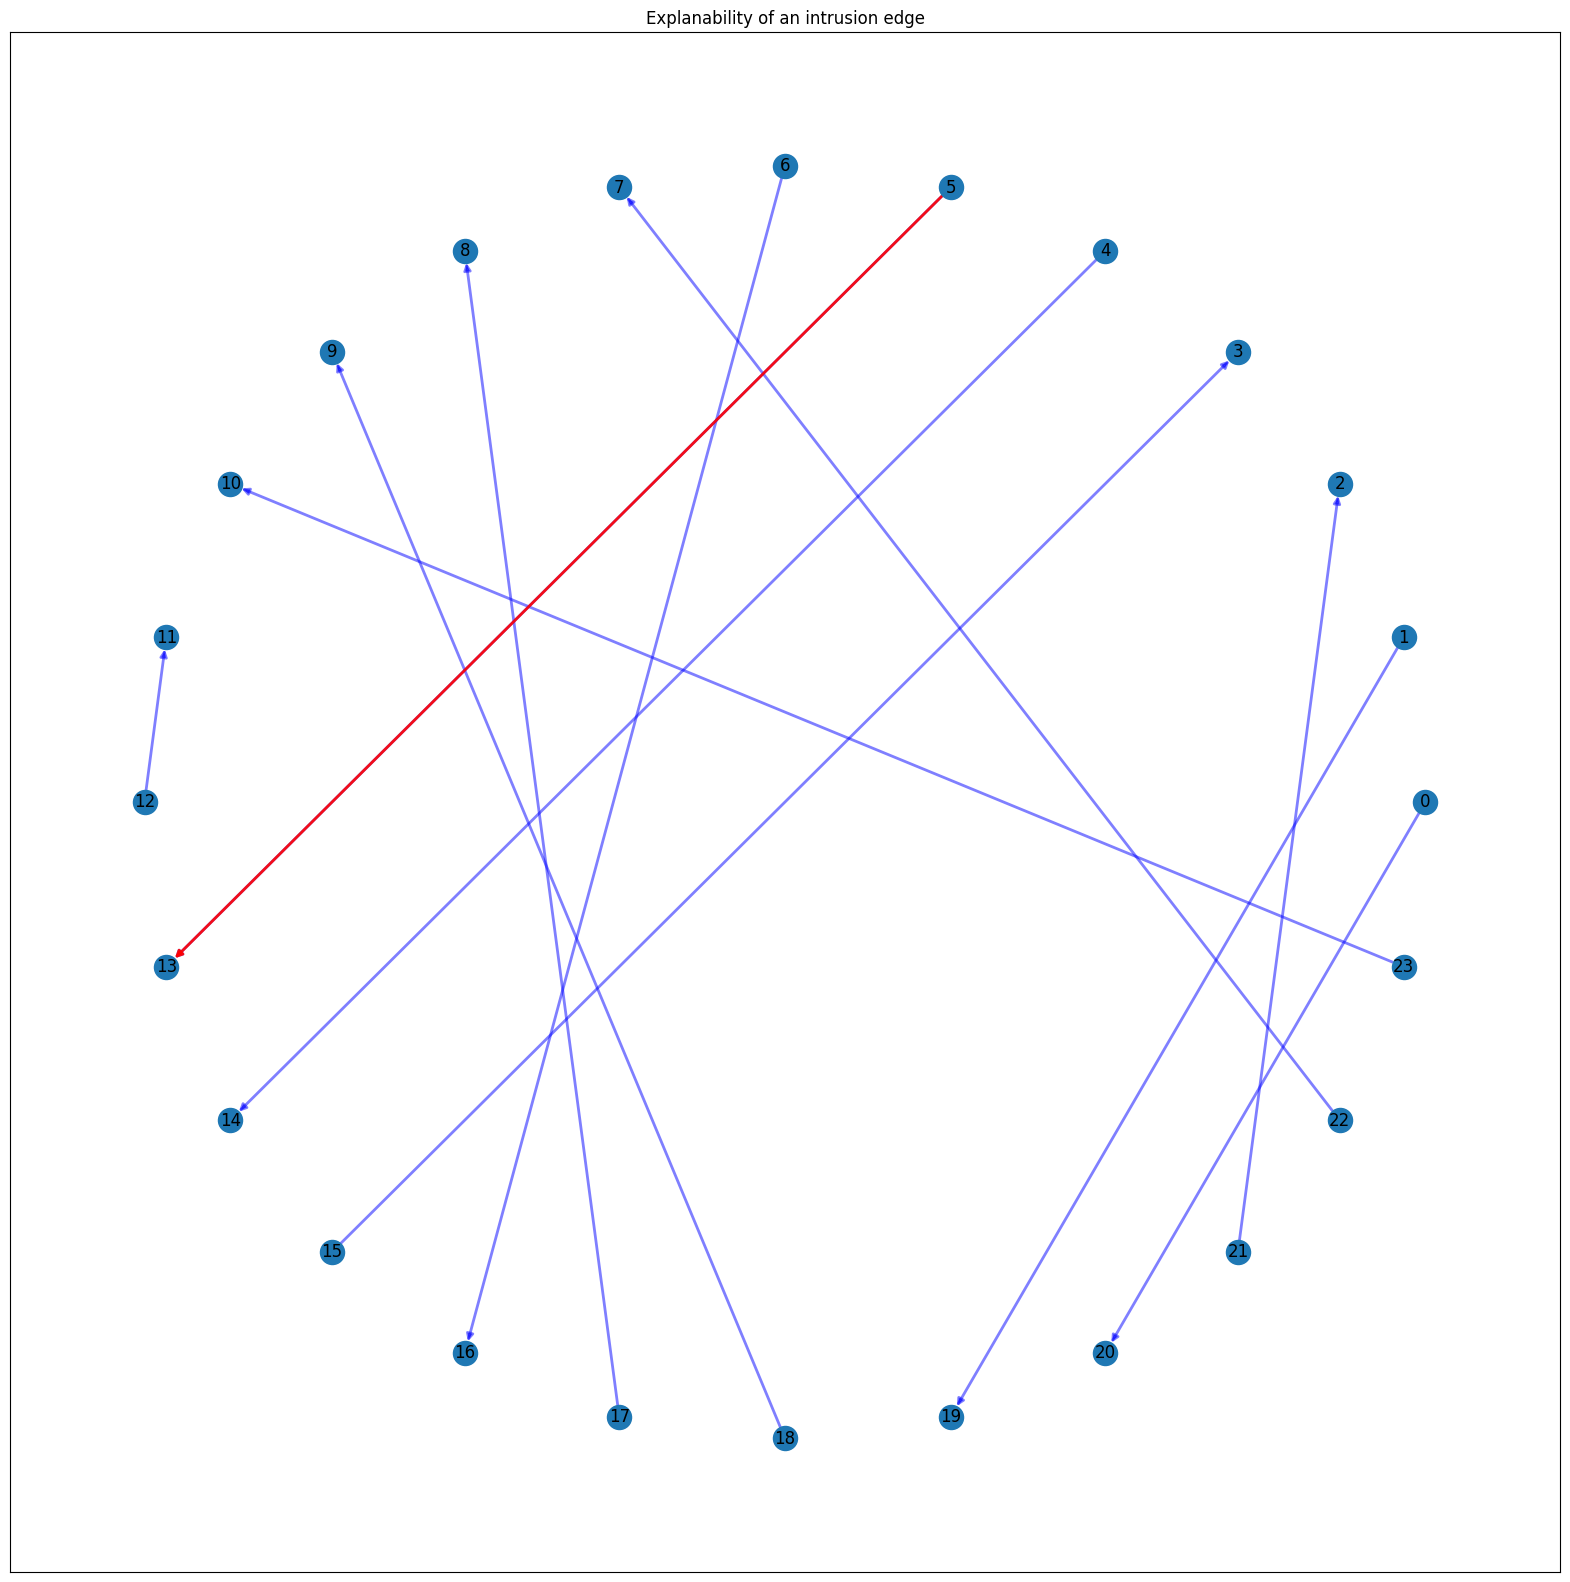

In [392]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[20,20])
plt.title("Explanability of an intrusion edge")
plot_graph= nx_graph_intrusion
pos = nx.circular_layout(plot_graph)

nx.draw_networkx_edges(plot_graph, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(plot_graph, pos)
nx.draw_networkx_labels(plot_graph, pos)

nx.draw_networkx_edges(
    plot_graph,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

# nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

/jobfs/144673024.gadi-pbs/ipykernel_1497975/308239378.py:21: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout


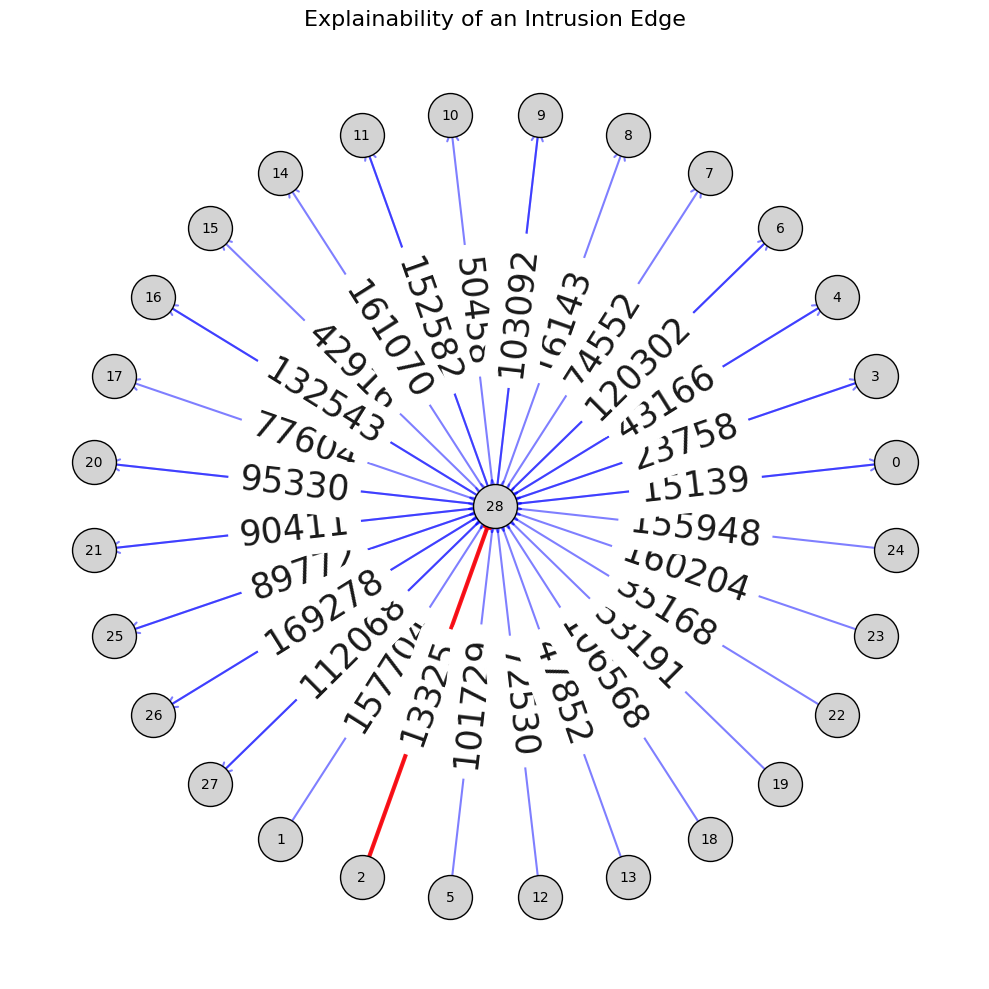

In [100]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Sample Graph Construction ===
# G = nx.MultiDiGraph()

# G.add_nodes_from(['Attacker', 'Gateway', 'Victim1', 'Victim2', 'Victim3'])

# G.add_edge('Attacker', 'Gateway', label='intrusion')
# G.add_edge('Gateway', 'Victim1', label='scan')
# G.add_edge('Gateway', 'Victim2', label='exploit')
# G.add_edge('Gateway', 'Victim3', label='connect')
# G.add_edge('Attacker', 'Victim3', label='secondary path')
G_plot=nx_graph_intrusion

# highlight_edge = ('Attacker', 'Gateway')
edge_labels = {(u, v): d['label'] for u, v, d in G_plot.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(10, 10))
plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G_plot,
    pos,
    width=1.5,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=20,
    # connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G_plot,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.9,
    edge_color='red',
    # connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G_plot,
    pos,
    font_size=10,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

nx.draw_networkx_edge_labels(
    G_plot,
    pos,
    edge_labels=edge_labelss,
    font_color=transparent_black,
    font_size=25
)

plt.axis('off')
plt.tight_layout()
plt.savefig("intrusion_graph_layout.pdf", dpi=300, bbox_inches='tight')
plt.show()


/jobfs/144673024.gadi-pbs/ipykernel_1497975/1967395664.py:22: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout


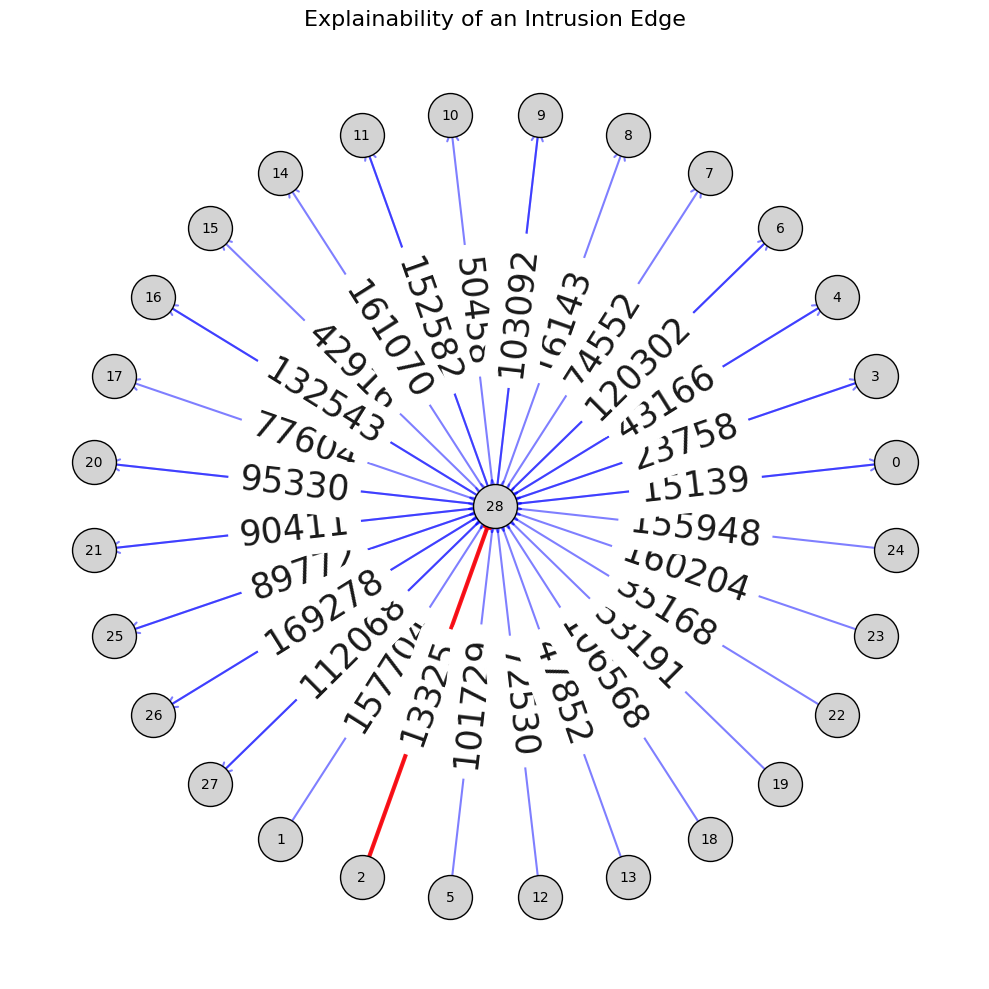

In [212]:
#for pg
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Sample Graph Construction ===
# G = nx.MultiDiGraph()

# G.add_nodes_from(['Attacker', 'Gateway', 'Victim1', 'Victim2', 'Victim3'])

# G.add_edge('Attacker', 'Gateway', label='intrusion')
# G.add_edge('Gateway', 'Victim1', label='scan')
# G.add_edge('Gateway', 'Victim2', label='exploit')
# G.add_edge('Gateway', 'Victim3', label='connect')
# G.add_edge('Attacker', 'Victim3', label='secondary path')
G_plot=nx_graph_intrusion

# highlight_edge = ('Attacker', 'Gateway')
edge_labels = {(u, v): d['label'] for u, v, d in G_plot.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(10, 10))
plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G_plot,
    pos,
    width=1.5,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=20,
    # connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G_plot,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.9,
    edge_color='red',
    # connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G_plot,
    pos,
    font_size=10,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

nx.draw_networkx_edge_labels(
    G_plot,
    pos,
    edge_labels=edge_labelss,
    font_color=transparent_black,
    font_size=25
)

plt.axis('off')
plt.tight_layout()
plt.savefig("intrusion_graph_layout.pdf", dpi=300, bbox_inches='tight')
plt.show()


# Evaluate Explainer

In [14]:
def train_and_test(explainer_name, ratio_perc_to_keep,sorted_list, class_idx):
    selected_samples = sorted_list[:len(sorted_list)*ratio_perc_to_keep//100]

    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
    class_weights = th.FloatTensor(class_weights).cuda()
    criterion = nn.CrossEntropyLoss(weight = class_weights)

    nfeats = G.ndata['h'][:, :, selected_samples]
    efeats = G.edata['h'][:, :, selected_samples]

    edge_label = G.edata['label']
    train_mask = G.edata['train_mask']

    model = Model(nfeats.shape[2], 128, nfeats.shape[2], F.relu, 0.2).cuda()
    opt = th.optim.Adam(model.parameters())

    # train_losses = []
    for epoch in range(1,200):
        pred = model(G, nfeats, efeats).cuda()
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        # train_losses.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

    node_features_test = G_test.ndata['feature'][:, :, selected_samples]
    edge_features_test = G_test.edata['h'][:, :, selected_samples]
    model.eval()
    test_pred = model(G_test, node_features_test, edge_features_test)
    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    report = classification_report(le.transform(actual), test_pred, output_dict=True) #labels=[class_idx]

    # Extract class 0 metrics
    class_metrics = report[str(class_idx)]

    del model,nfeats,efeats
    return {
        'dataset': ratio_perc_to_keep,
        'model': explainer_name,
        'f1_macro': class_metrics['f1-score'],
        'precision': class_metrics['precision'],
        'recall': class_metrics['recall']
    }

In [15]:
sorted_items_pg = {0: [3, 1, 0, 4, 6, 2, 5, 7], 1: [5, 7, 0, 3, 1, 4, 6, 2], 2: [1, 4, 7, 0, 3, 5, 6, 2], 3: [7, 0, 1, 6, 3, 2, 5, 4]}
sorted_items_gnn = {0: [5, 1, 4, 7, 3, 6, 2, 0], 1: [5, 2, 4, 3, 0, 7, 6, 1], 2: [2, 4, 3, 5, 0, 7, 1, 6], 3: [4, 7, 1, 3, 2, 5, 6, 0]}

In [16]:
last = {
    0: {
        "Precision": 0.2689,
        "Recall": 0.8546,
        "F1-score": 0.4091  
    },
    1: {
        "Precision":0.7825,
        "Recall": 0.9695,
        "F1-score": 0.8660
    },
    2: {
        "Precision": 0.9930,
        "Recall": 0.8632,
        "F1-score": 0.9236
    },
   3: {
        "Precision": 0.2551,
        "Recall": 0.7471,
        "F1-score": 0.3803
    }
}

In [ ]:
#last
# # acc_ref= 0.994
# f1_macro_ref=0.37
# precision_ref=0.23
# recall_ref=0.99

# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.2689    0.8546    0.4091    0.8546    8354      
# DoS            0.7825    0.9695    0.8660    0.9695    68468     
# Reconnaissance 0.9930    0.8632    0.9236    0.8632    282026    
# Theft          0.2551    0.7471    0.3803    0.7471    1202      

# Overall Accuracy:
# Accuracy: 0.8828

# Weighted Averages:
# {'precision': 0.9337421989219714, 'recall': 0.8828218303013471, 'f1-score': 0.8988798792901675, 'support': 360050.0}

## For Benign

======Class type explaining: ['Benign'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:51<02:33, 51.04s/it]

Running 40


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 50%|█████     | 2/4 [01:41<01:41, 50.99s/it]

Running 60


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 75%|███████▌  | 3/4 [02:33<00:51, 51.07s/it]

Running 80


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:50<02:31, 50.41s/it]

Running 40


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 50%|█████     | 2/4 [01:41<01:41, 50.93s/it]

Running 60


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 75%|███████▌  | 3/4 [02:32<00:51, 51.01s/it]

Running 80


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 4/4 [03:24<00:00, 51.06s/it]


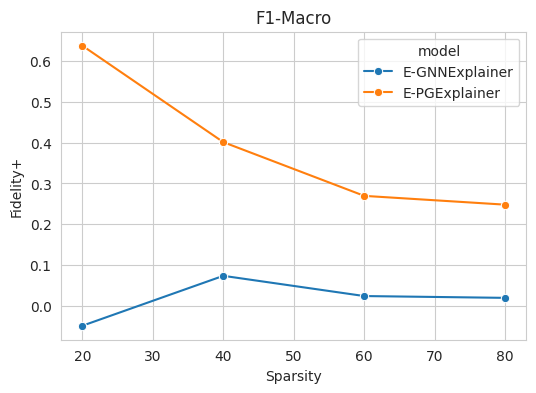

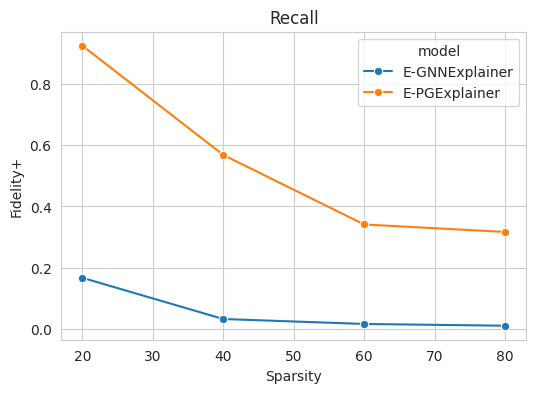

======Class type explaining: ['DoS'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/4 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for class_idx in range(4):
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results,
      x='dataset',
      y='f1_macro_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
  plt.show()
  fig = ax.get_figure()

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
      x='dataset',
      y='recall_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
  plt.show()
  fig = ax.get_figure()


======Class type explaining: ['DoS'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:22<01:08, 22.72s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:45<00:45, 22.81s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:08<00:22, 22.84s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:22<01:08, 22.70s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:45<00:45, 22.80s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:08<00:22, 22.84s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:31<00:00, 22.86s/it]


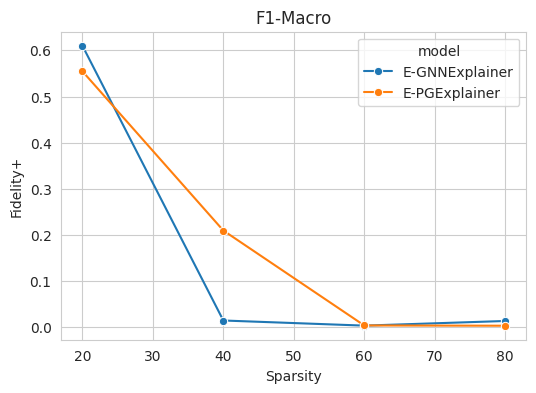

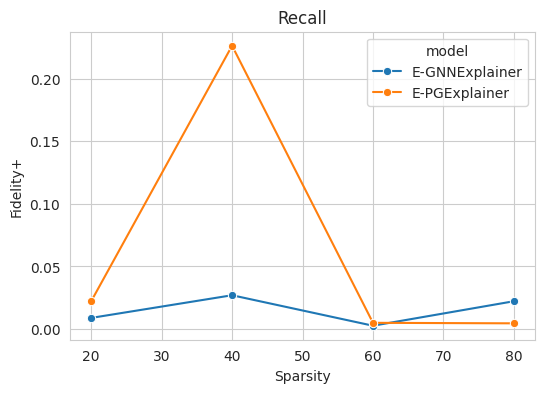

======Class type explaining: ['Reconnaissance'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:22<01:08, 22.73s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:45<00:45, 22.82s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:08<00:22, 22.85s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:22<01:08, 22.71s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:45<00:45, 22.82s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:08<00:22, 22.85s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:31<00:00, 22.87s/it]


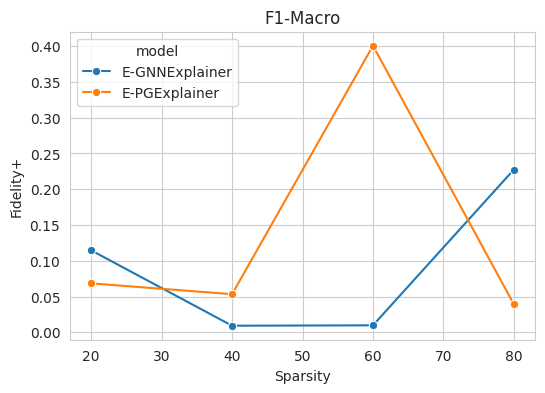

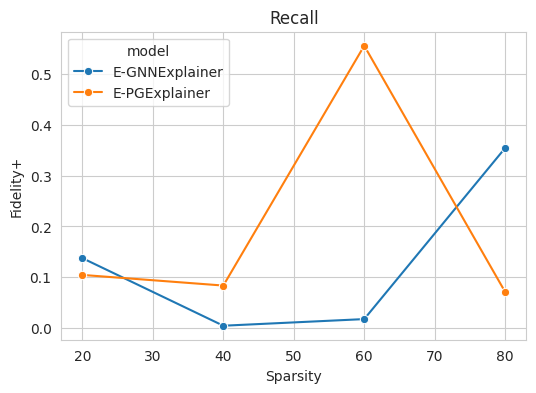

======Class type explaining: ['Theft'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:22<01:08, 22.72s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:45<00:45, 22.82s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:08<00:22, 22.84s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:22<01:08, 22.70s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:45<00:45, 22.80s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:08<00:22, 22.84s/it]/jobfs/145053153.gadi-pbs/ipykernel_2101674/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:31<00:00, 22.86s/it]


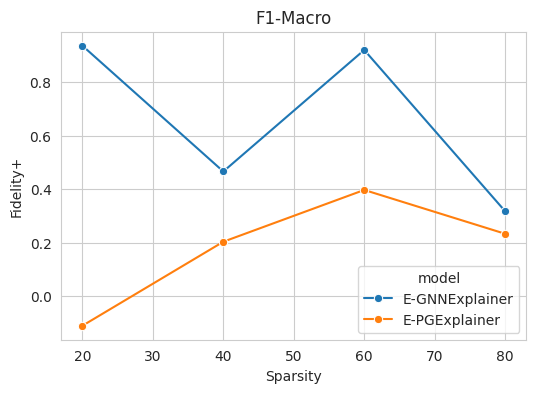

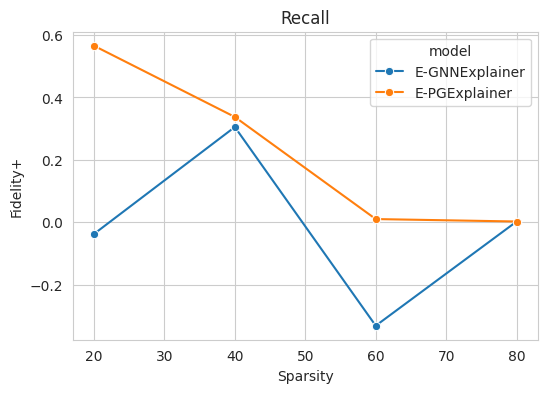

In [21]:
for class_idx in range(1,4):
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results,
      x='dataset',
      y='f1_macro_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
  plt.show()
  fig = ax.get_figure()

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
      x='dataset',
      y='recall_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
  plt.show()
  fig = ax.get_figure()


In [ ]:
#20 min for one class eval generation

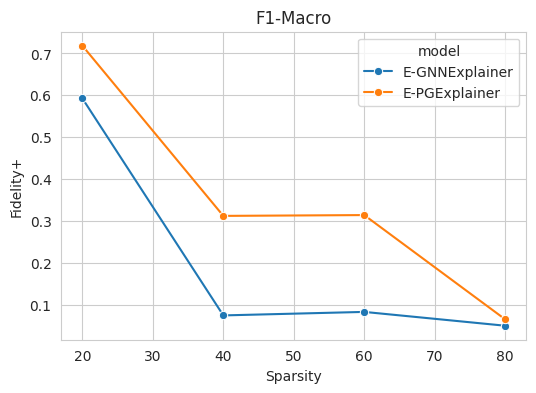

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
plt.show()
fig = ax.get_figure()

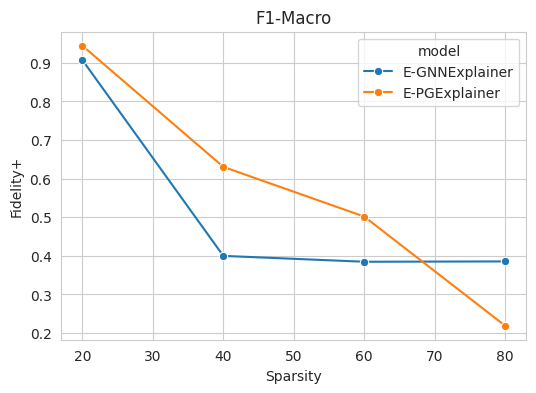

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
plt.show()
fig = ax.get_figure()

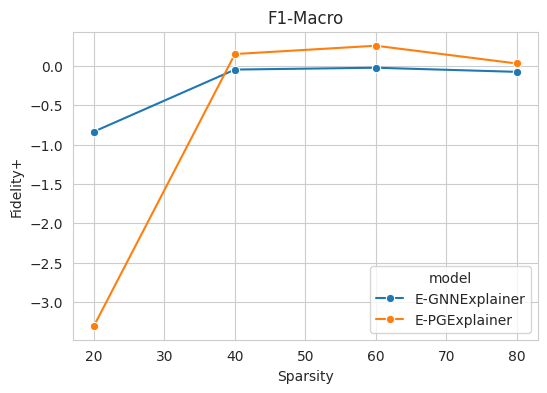

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='precision_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Precision")
plt.show()
fig = ax.get_figure()

# OvA Model


In [19]:
global emb
global score_global
emb ={key: [] for key in range(number_of_classes)}
score_global ={key: [] for key in range(number_of_classes)}

In [20]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(number_of_classes)])

    def apply_edges(self, edges, class_idx, test,apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        if apply_sigmoid:
            score = torch.sigmoid(logits) #logits[:,1] #torch.sigmoid(logits)[:,1]
        else:
            score = logits
        # score = logits
        if test:
            emb[class_idx]= th.cat([h_u, h_v], 1)
            score_global[class_idx] = score
        return {'score': score}
    def forward(self, graph, h,test,class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,test, apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,test,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, eweight=None, feature_weight=None, test=False,class_idx=None):
      if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
          # efeats *= weights
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h,test,class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h,test)

In [21]:
from sklearn.utils import class_weight
class_weights_list = []
for i in range(number_of_classes):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([ 0.5119, 21.5886], device='cuda:0'),
 tensor([0.5522, 5.2890], device='cuda:0'),
 tensor([0.5523, 5.2819], device='cuda:0'),
 tensor([2.3207, 0.6373], device='cuda:0'),
 tensor([  0.5016, 161.5654], device='cuda:0')]

In [22]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        optimizer.zero_grad()
        selected_efeatures = efeats
        selected_nfeatures = nfeats

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        # pos_weight = class_weights_list[class_idx][0] / (class_weights_list[class_idx][1] + 1e-6)
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


0.30766861140727997
0.28339311182498933
0.2930832296609879
0.2877205178141594
0.2718504548072815
0.2727020025253296
0.26644738018512726


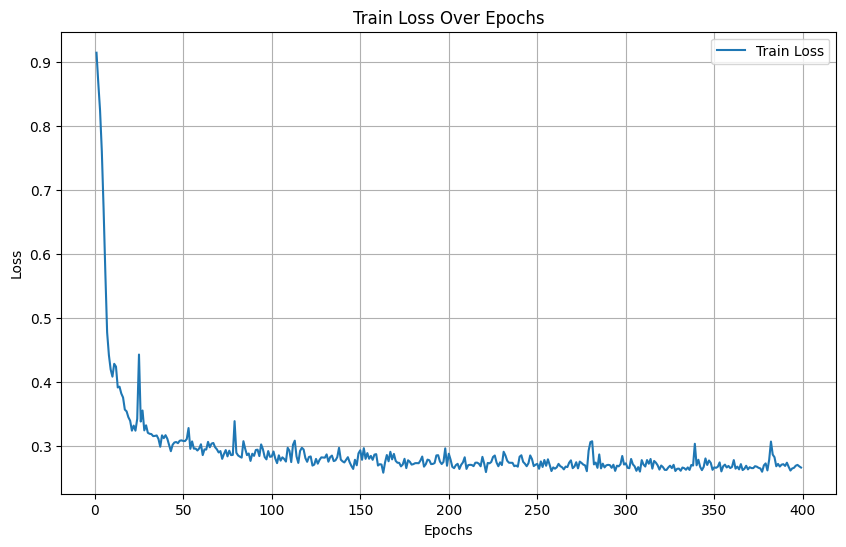

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(8, 128, 8, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,400):#400
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, number_of_classes)
    train_losses.append(avg_loss)
    if epoch % 50 == 0:
        print(avg_loss)

epochs = range(1, 400)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def predict_one_vs_all(model,graph,node_feat, edge_feat):
    model.eval()

    with th.no_grad():
        # Forward pass to get binary classifier outputs for all classes
        outputs = model(graph, nfeats, efeats,test = True)
        # new_df=outputs.cpu().detach().numpy()
        # new_df=pd.DataFrame(outputs.squeeze().cpu())
        # print(outputs.squeeze().shape)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes #, new_df

nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats) #, new_df
predicted_classes.unique()

tensor([0, 1, 2, 3, 4], device='cuda:0')

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])
0.014568910002708435 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
=================================================================
Benign         0.2620    0.9973    0.4150    0.9973    8260      
DDoS           0.3601    0.3731    0.3665    0.3731    34264     
DoS            0.4091    0.6003    0.4866    0.6003    34136     
Reconnaissance 0.9971    0.8485    0.9168    0.8485    282182    
Theft          0.1839    0.4384    0.2591    0.4384    1218      

Overall Accuracy:
Accuracy: 0.7818

Weighted Averages:
{'precision': 0.8611295817591849, 'recall': 0.7817613731044826, 'f1-score': 0.8099282026322722, 'support': 360060.0}

Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.5838    0.6557    0.6177    0.6557    8260      
DDoS           0.3734    0.7740    0.5038    0.7740    34264     
DoS            0.4826    0.2030    0.2858    0.2030    34136     
Reconnaissance 0.9866    0.9189    0.9516    0.9189    282182    
Theft          0.2054    0.4335    0.2788    0.4335    1218      

Overall Accuracy:
Accuracy: 0.8296

Weighted Averages:
{'precision': 0.8685834032463452, 'recall': 0.8295950674887519, 'f1-score': 0.835903286314167, 'support': 360060.0}


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.5489    0.6299    0.5866    0.6299    8354      
DoS            0.7815    0.9686    0.8651    0.9686    68468     
Reconnaissance 0.9861    0.9169    0.9502    0.9169    282026    
Theft          0.2608    0.7363    0.3852    0.7363    1202      

Overall Accuracy:
Accuracy: 0.9194

Weighted Averages:
{'precision': 0.9346597202919994, 'recall': 0.9194361894181363, 'f1-score': 0.9237162212013057, 'support': 360050.0}


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, le.inverse_transform(predicted_classes.cpu())),
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [ ]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# OvA - With Class wise features

In [12]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(4)])

    def apply_edges(self, edges, class_idx, apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        # if apply_sigmoid:
        #     score = logits[:,1] #torch.sigmoid(logits)[:,1]
        # else:
        #     score = logits
        score = logits
        return {'score': score}
    def forward(self, graph, h, class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None,class_idx=None):
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h, class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h)

In [13]:
class_weights_list = []
for i in range(4):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([ 0.5118, 21.7177], device='cuda:0'),
 tensor([0.6166, 2.6438], device='cuda:0'),
 tensor([2.3228, 0.6372], device='cuda:0'),
 tensor([  0.5016, 160.5749], device='cuda:0')]

In [31]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes, selected_features_per_class):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        optimizer.zero_grad()
        selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
        selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        # weight = th.log(1 + class_weights_list[class_idx][1]) #[class_weights_list[class_idx][1]]
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


In [15]:
def predict_one_vs_all(model,graph,nfeats, efeats,selected_features_per_class):
    model.eval()

    with th.no_grad():
        outputs = []
        for class_idx in range(4):
          selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
          selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

          logits = model(graph, selected_nfeatures, selected_efeatures, class_idx=class_idx).cuda()

          outputs.append(logits)#torch.sigmoid(logits)[:,0]

        outputs = th.stack(outputs, dim=1)  # Shape: (num_nodes, num_classes)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes

# nfeats = G_test.ndata['feature']
# efeats = G_test.edata['h']
# predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats)
# predicted_classes.unique()

In [16]:
# selected_features_per_class=final_features
# for e -gnn
selected_features_per_class_gnn ={0: [2, 6, 4, 1, 5, 7, 0, 3], 1: [3, 5, 1, 6, 7, 0, 4, 2], 2: [1, 5, 6, 0, 7, 4, 2, 3], 3: [5, 3, 0, 4, 6, 1, 2, 7]}

#for e-pg
selected_features_per_class_pg = {0: [7, 4, 5, 6, 1, 3, 2, 0], 1: [7, 0, 5, 2, 4, 6, 1, 3], 2: [0, 7, 5, 1, 4, 3, 2, 6], 3: [3, 0, 2, 4, 7, 5, 1, 6]}


## With E-GNNExplainer

In [ ]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_gnn
df_ova_results=[]

for num in range(8,4,-1): #8,0,-1
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,150):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


/tmp/ipython-input-117-147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipython-input-117-147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserW

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.923644,0.934425,0.919569
1,7,0.918894,0.934502,0.913606
2,6,0.925467,0.935468,0.921782
3,5,0.916671,0.932932,0.910054
4,4,0.916497,0.932908,0.909151
5,3,0.916238,0.925677,0.913251
6,2,0.922558,0.932574,0.919400
7,1,0.881166,0.915204,0.868433


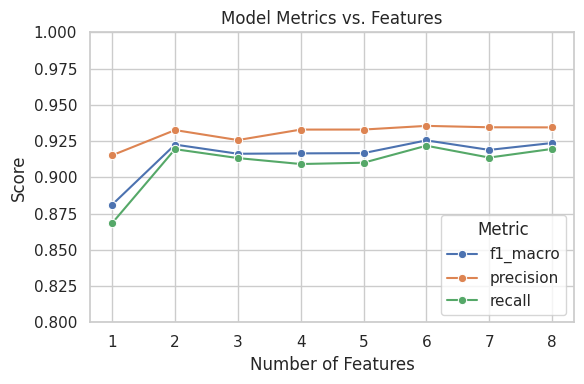

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.922021,0.932665,0.917945
1,7,0.920364,0.931868,0.915842
2,6,0.916812,0.931629,0.910627
3,5,0.919109,0.931609,0.914054


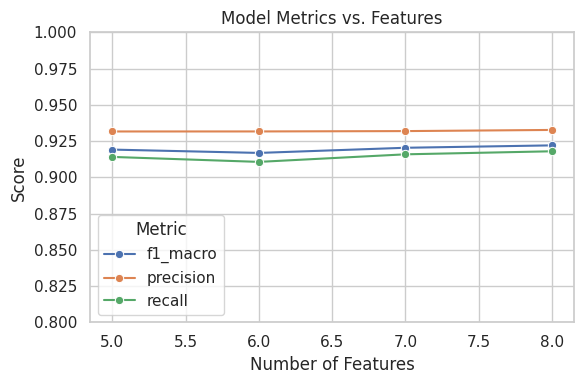

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## With E-PGExplainer

In [ ]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

for num in range(8,3,-1):
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,200):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


In [91]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.918776,0.933088,0.912757
1,7,0.922196,0.932270,0.918020
2,6,0.920691,0.933012,0.915545
3,5,0.923213,0.930358,0.922575
4,4,0.824503,0.835366,0.817670


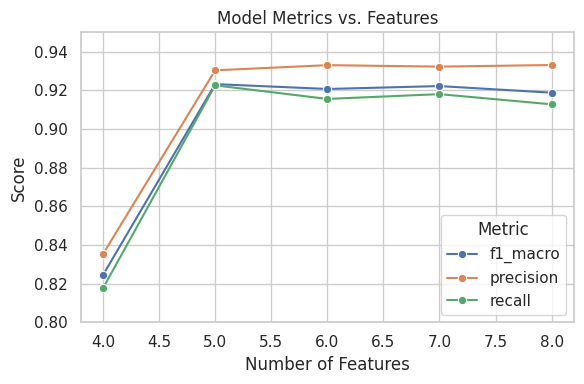

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.80, 0.95)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig("/scratch/kc01/na3038/TrainedModels/plot.png")
plt.show()

In [118]:
le.inverse_transform(actual.cpu())

array(['Reconnaissance', 'Reconnaissance', 'Reconnaissance', ...,
       'Benign', 'Reconnaissance', 'Reconnaissance'], dtype=object)

/jobfs/144673024.gadi-pbs/ipykernel_1497975/2617805454.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.28490379825234413
0.2570318728685379
0.24397360906004906
0.24225715175271034
0.2614169344305992
0.23362596333026886
0.20573393628001213
150.00932693574578 seconds


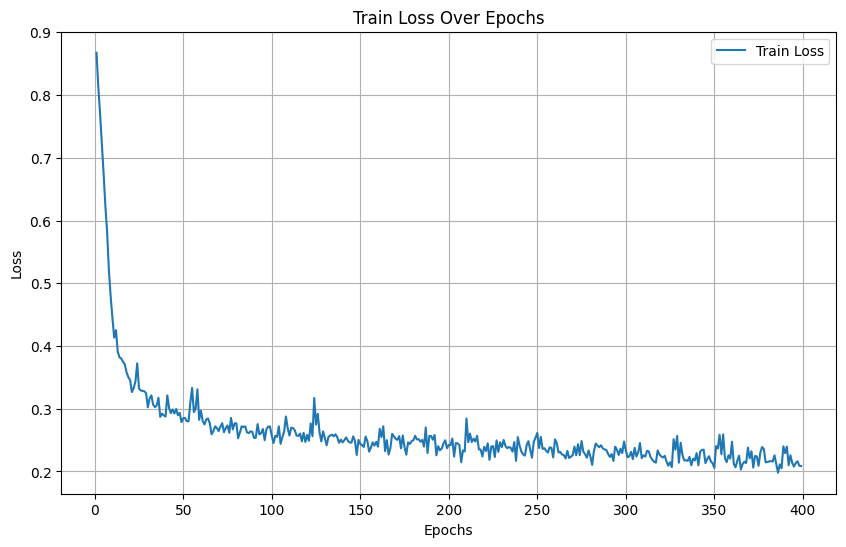

In [34]:
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=5
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

train_losses = []
for epoch in range(1,400):#200
  avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
  train_losses.append(avg_loss)
  if epoch % 50 ==0:
      print(avg_loss)

elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

epochs = range(1, 400)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
start_time = timeit.default_timer()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

# actual=le.inverse_transform(actual.cpu())
test_pred= le.inverse_transform(predicted_classes.squeeze().cpu())
report = classification_report(actual, test_pred, output_dict=True)

header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg']) #400 epoch

0.10188800282776356 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.7827    0.5174    0.6229    0.5174    8354      
DoS            0.7752    0.9869    0.8683    0.9869    68468     
Reconnaissance 0.9815    0.9276    0.9538    0.9276    282026    
Theft          0.8081    0.5641    0.6644    0.5641    1202      

Overall Accuracy:
Accuracy: 0.9281

Weighted Averages:
{'precision': 0.9371073521288162, 'recall': 0.9281238716844883, 'f1-score': 0.9288969779877068, 'support': 360050.0}


In [25]:
# 0.10108992643654346 seconds - for 400 trained epoch results
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.7410    0.5014    0.5981    0.5014    8354      
# DoS            0.7744    0.9438    0.8507    0.9438    68468     
# Reconnaissance 0.9755    0.9269    0.9506    0.9269    282026    
# Theft          0.2779    0.6830    0.3951    0.6830    1202      

# Overall Accuracy:
# Accuracy: 0.9195

# Weighted Averages:
# {'precision': 0.9294592905854451, 'recall': 0.9194611859463964, 'f1-score': 0.9215671931399806, 'support': 360050.0}

# 0.09834042377769947 seconds - 600 epoch
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.3018    0.7223    0.4257    0.7223    8354      
# DoS            0.7768    0.9803    0.8667    0.9803    68468     
# Reconnaissance 0.9876    0.8842    0.9330    0.8842    282026    
# Theft          0.5859    0.5674    0.5765    0.5674    1202      

# Overall Accuracy:
# Accuracy: 0.8976

# Weighted Averages:
# {'precision': 0.9302684575596403, 'recall': 0.8976281072073323, 'f1-score': 0.907463928520066, 'support': 360050.0}

# 0.10279137548059225 seconds - 600 epoch with log class weights
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.9532    0.4634    0.6236    0.4634    8354      
# DoS            0.7781    0.9877    0.8705    0.9877    68468     
# Reconnaissance 0.9792    0.9325    0.9553    0.9325    282026    
# Theft          0.9165    0.3652    0.5223    0.3652    1202      

# Overall Accuracy:
# Accuracy: 0.9302

# Weighted Averages:
# {'precision': 0.9401089722608602, 'recall': 0.9302402444104986, 'f1-score': 0.930001043655209, 'support': 360050.0}

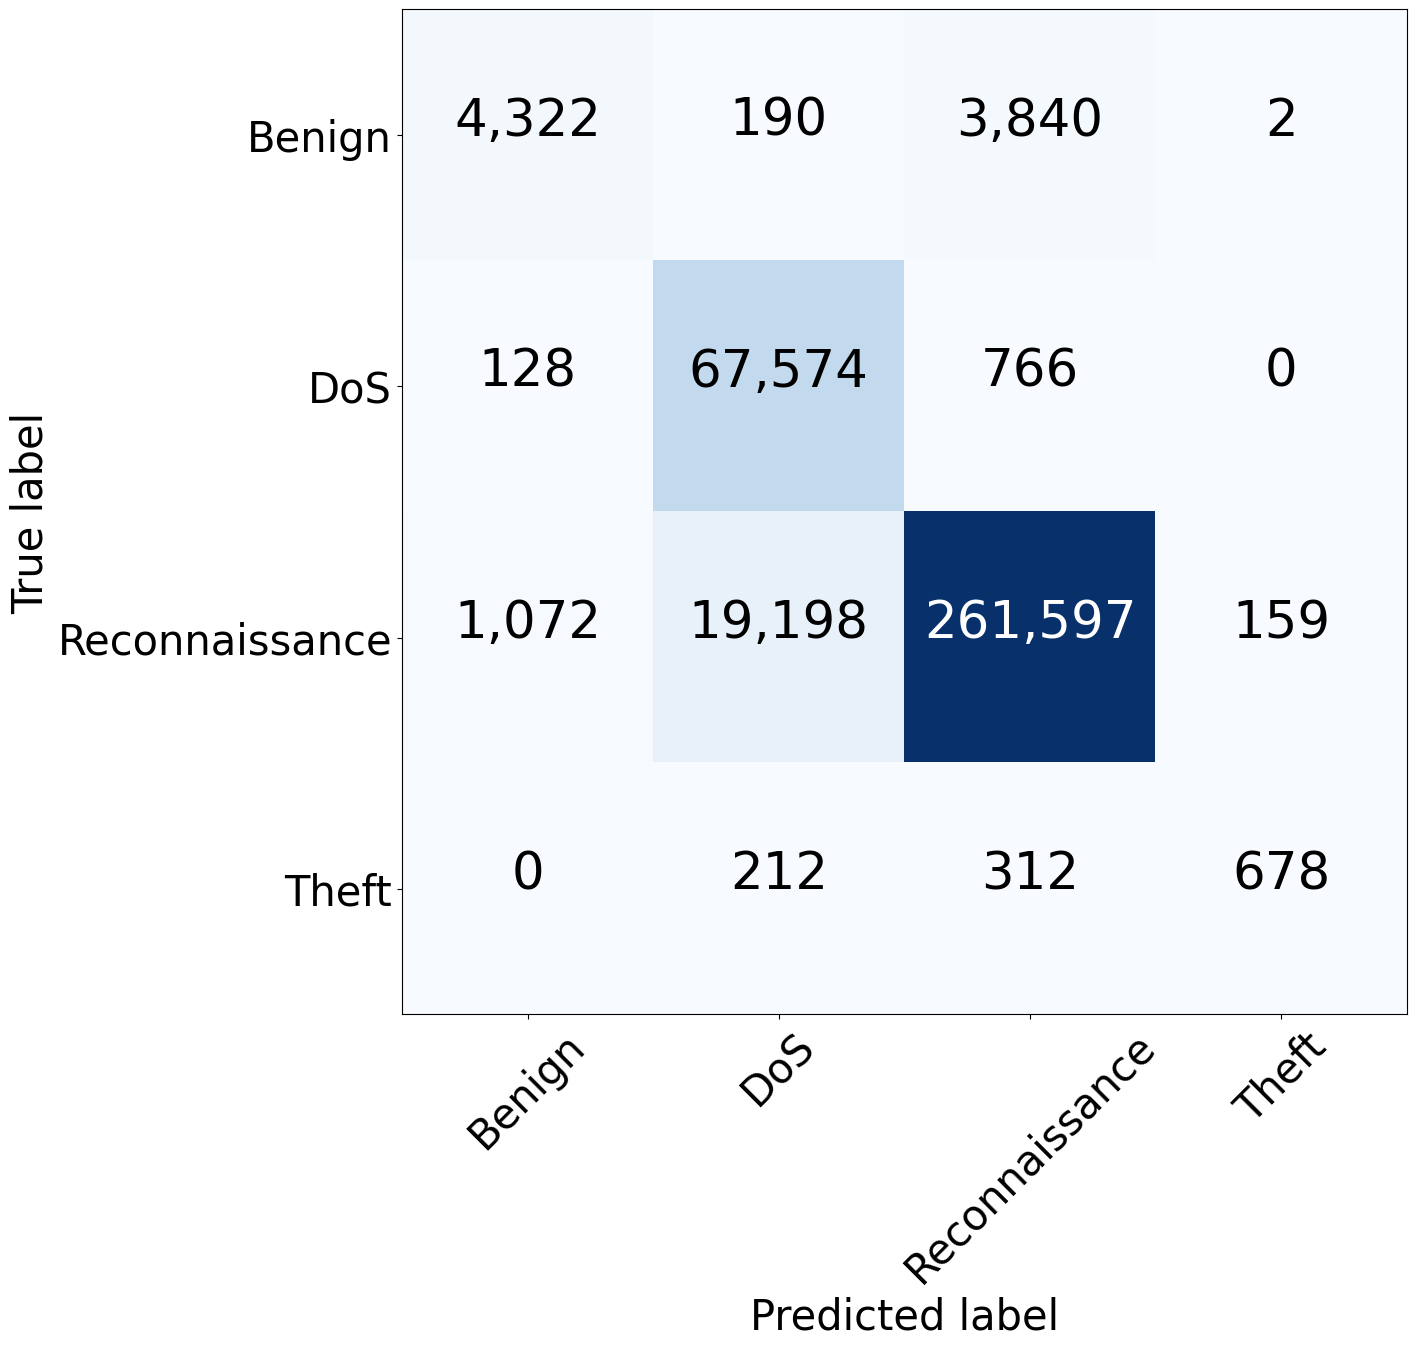

In [36]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=30,
                          text_fontsize=37):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.xticks(np.arange(4), labels=np.arange(4), fontsize=14)
    plt.yticks(np.arange(4), labels=np.arange(4), fontsize=14)
    plt.grid(False)
    # plt.ylim(cm.shape[0]-0.5, -0.5)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig("/scratch/kc01/na3038/TrainedModels/cm.png")
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      # title        = "Confusion Matrix"
                      )

In [37]:
predicted_classes.cpu().unique()

tensor([0, 1, 2, 3])

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


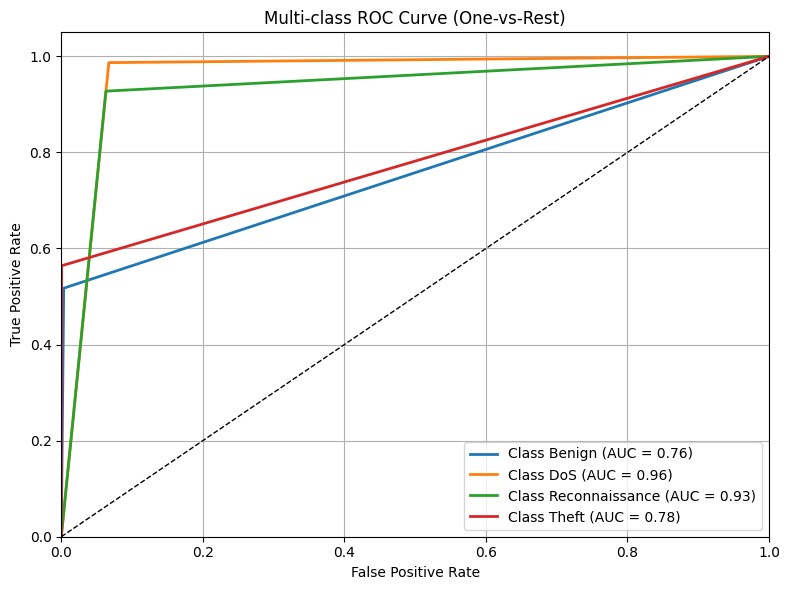

In [38]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Explain Dos/DDoS

In [ ]:
model.pred.classifiers[0]

Linear(in_features=256, out_features=1, bias=True)

In [ ]:
def predict_one_vs_all(model,graph,node_feat, edge_feat, class_indx):
    model.eval()

    with th.no_grad():
        # Forward pass to get binary classifier outputs for all classes
        outputs = model(graph, node_feat, edge_feat,class_idx=class_indx)
        outputs = th.sigmoid(outputs)
        predicted_classes = (outputs >= 0.50).int()

        # new_df=outputs.cpu().detach().numpy()
        # new_df=pd.DataFrame(outputs.squeeze().cpu())
        # print(outputs.squeeze().shape)
    #     predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes #, new_df

In [ ]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats, class_indx=1)
predicted_classes.unique()
# predict_one_vs_all(model,G_test, nfeats ,efeats, class_indx=0)

tensor([0, 1], device='cuda:0', dtype=torch.int32)

In [ ]:
binary_labels = (actual == 1).int()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(binary_labels, predicted_classes.cpu(), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
0              1.00      0.93      0.96      0.932     291868    
1              0.77      1.00      0.87      1.000     68192     

Overall Accuracy:
Accuracy: 0.94

Weighted Averages:
{'precision': 0.9571342597157868, 'recall': 0.9446120091095929, 'f1-score': 0.9471641349396115, 'support': 360060.0}


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_true = binary_labels.cpu().detach().numpy()
y_scores = predicted_classes.squeeze().cpu().detach().numpy()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate AUC for Precision-Recall curve
pr_auc = auc(recall, precision)

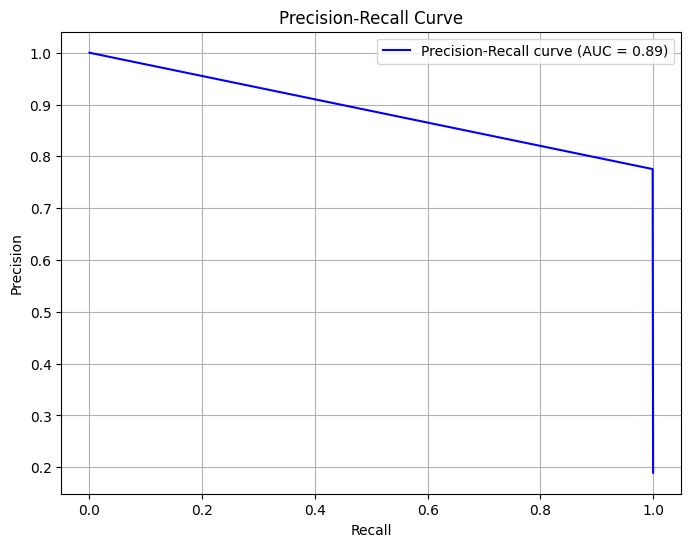

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# actual = le.inverse_transform(actual)
# test_pred = le.inverse_transform(predicted_classes)

dos_true_positives = []
for i in range(len(y_true)):
    if y_scores[i]==1 and y_scores[i] == y_true[i]:
      dos_true_positives.append(G_test.edata['Edge_indx'][i].cpu().item())

In [ ]:
len(true_positives)

68138

In [ ]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']

attack_edge_to_explain = 0 #initialize
attack_feature_array = {}
true_predicted_edge_indexes = random.sample(dos_true_positives, 10)
for edge_index in true_predicted_edge_indexes:
      attack_indices_list = (G_test.edata['Edge_indx'] == edge_index).nonzero(as_tuple=True)[0].to("cuda").tolist()
      if len(true_predicted_edge_indexes)>0:
        attack_edge_to_explain = attack_indices_list[0]
        attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats, class_idx=1)
        attack_feature_array[edge_index] = (attck_efeat_mask.cpu().detach().tolist())
lists = list(attack_feature_array.values())
averages = [sum(values) / len(values) for values in zip(*lists)]

feature_importance = {}
for i in range(8):
  feature_importance[cols_to_norm[i]]=averages[i]

del true_predicted_edge_indexes, attack_feature_array, lists, averages, feature_importance #, sorted_items
torch.cuda.empty_cache()
print(feature_importance)

KeyError: 'label'

# Local Explanations

### Benign

In [ ]:
attk_class = 'DoS'
print('Class type explaining:', attk_class)
# attack_edge_to_explain = 0 #initialize
# attack_feature_array = {}
true_predicted_benign_edge_index = 13 #random.sample(true_positives[attk_class], 1) #true_predicted_edge_index
true_predicted_benign_edge_index

Class type explaining: DoS


13

In [ ]:
attack_edge_to_explain = list((G_test.edata['Edge_indx'] == true_predicted_benign_edge_index).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
attack_edge_to_explain

2

In [ ]:
attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
edge_feature_importance = (attck_efeat_mask.cpu().detach().tolist())

In [ ]:
feature_importance = {}
for i in range(8):
  feature_importance[cols_to_norm[i]]=edge_feature_importance[0][i]
sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_items:
  print(f'{key}: {value}')

OUT_BYTES: 0.8523483276367188
L7_PROTO: 0.8491301536560059
IN_BYTES: 0.737597644329071
TCP_FLAGS: 0.6260159611701965
OUT_PKTS: -0.5418569445610046
PROTOCOL: -0.6635388731956482
IN_PKTS: -0.7264429926872253
FLOW_DURATION_MILLISECONDS: -0.8527140617370605


In [ ]:
attck_efeat_sub_graph

Graph(num_nodes=167208, num_edges=56525,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
true_positives['DoS']

[0,
 0,
 13,
 18,
 30,
 41,
 63,
 66,
 82,
 111,
 166,
 189,
 191,
 198,
 212,
 224,
 242,
 267,
 275,
 282,
 289,
 290,
 307,
 326,
 328,
 332,
 346,
 355,
 384,
 391,
 399,
 406,
 425,
 430,
 431,
 441,
 446,
 468,
 479,
 500,
 515,
 519,
 533,
 537,
 565,
 569,
 598,
 629,
 635,
 642,
 651,
 671,
 684,
 728,
 769,
 778,
 779,
 802,
 811,
 814,
 843,
 881,
 896,
 917,
 926,
 941,
 958,
 985,
 1008,
 1010,
 1019,
 1028,
 1029,
 1046,
 1050,
 1058,
 1067,
 1068,
 1098,
 1111,
 1127,
 1129,
 1151,
 1162,
 1174,
 1175,
 1183,
 1209,
 1227,
 1232,
 1238,
 1248,
 1254,
 1266,
 1288,
 1297,
 1305,
 1312,
 1358,
 1367,
 1376,
 1377,
 1397,
 1398,
 1446,
 1452,
 1470,
 1471,
 1478,
 1479,
 1480,
 1505,
 1509,
 1537,
 1557,
 1558,
 1570,
 1582,
 1591,
 1594,
 1595,
 1648,
 1657,
 1671,
 1693,
 1696,
 1722,
 1724,
 1747,
 1761,
 1766,
 1767,
 1778,
 1779,
 1787,
 1811,
 1835,
 1843,
 1846,
 1854,
 1864,
 1869,
 1870,
 1873,
 1883,
 1890,
 1899,
 1948,
 1955,
 1963,
 1977,
 1978,
 1979,
 1982,
 

In [ ]:
num_hops = 2
source_node = G_test.edges()[0][2].item()
sg, inverse_indices = khop_in_subgraph(G_test, source_node, num_hops)
sg

Graph(num_nodes=14060, num_edges=28118,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
G_test.edges()

(tensor([100782, 188616, 188616,  ...,  34183,  81931, 178447], device='cuda:0'),
 tensor([188616, 100782, 179456,  ..., 184316, 185576, 185990], device='cuda:0'))

In [ ]:
G_test.nodes()

tensor([     0,      1,      2,  ..., 188815, 188816, 188817], device='cuda:0')

In [ ]:
G_test.edges()[0][2].item()

188616

In [ ]:
G_test.edata['Edge_indx']

tensor([     0,      0,     13,  ..., 180027, 180028, 180029], device='cuda:0')

In [ ]:
X_test.iloc[13]

,47083
IPV4_SRC_ADDR,172.30.88.50:58690
IPV4_DST_ADDR,192.168.100.7:80
PROTOCOL,0.257369
L7_PROTO,-1.665568
IN_BYTES,-0.018551
OUT_BYTES,-0.00641
IN_PKTS,-0.029746
OUT_PKTS,-0.007791
TCP_FLAGS,-1.381534
FLOW_DURATION_MILLISECONDS,0.487975


In [ ]:
X_test[X_test['IPV4_SRC_ADDR']=='172.30.88.50:58690']

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h
47083,172.30.88.50:58690,192.168.100.7:80,0.257369,-1.665568,-0.018551,-0.00641,-0.029746,-0.007791,-1.381534,0.487975,1,13,"[-0.006409981374379563, -0.007791121753422729,..."


In [ ]:
X_test[X_test.index==188616]

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h


In [ ]:
X_test.index.shape

NameError: name 'X_test' is not defined

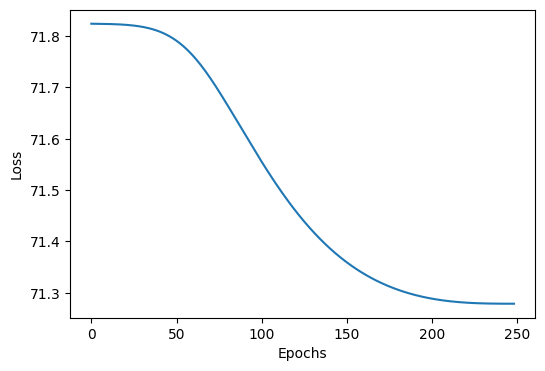

In [ ]:
attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model, attack_edge_to_explain, G_test, nfeats, efeats,class_idx=1)

In [ ]:
attck_edge_mask.shape

torch.Size([28118])

In [ ]:
attck_sub_graph

Graph(num_nodes=14060, num_edges=28118,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
attck_edge_mask[attck_edge_mask > 0.8].unique()

tensor([0.8846, 0.8850, 0.8851,  ..., 0.8866, 0.8866, 0.8866], device='cuda:0')

In [ ]:
# edge_mask_intrusion_round = th.round(attck_edge_mask)
# unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
unwanted_1 = list((attck_edge_mask < 0.8866).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if attck_edge_indice in unwanted_1:
    unwanted_1.remove(attck_edge_indice)

In [ ]:
len(unwanted_1)

27284

In [ ]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

In [ ]:
g_intrusion

Graph(num_nodes=822, num_edges=834,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/g_intrusion.dgl"
save_graphs(file_path, g_intrusion)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
g_intrusion = loaded_graphs[0]

# Verify the loaded graph (optional)
print(g_intrusion)

Graph(num_nodes=822, num_edges=834,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64)})


In [ ]:
nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)
nx_graph_intrusion

In [ ]:
nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "label")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = valuess[indx].item()

In [ ]:
edge_labelss

{(0, 821): 1,
 (2, 821): 1,
 (3, 821): 1,
 (4, 821): 1,
 (6, 821): 1,
 (7, 821): 1,
 (10, 821): 1,
 (12, 821): 1,
 (16, 821): 1,
 (17, 821): 1,
 (18, 821): 1,
 (19, 821): 1,
 (21, 821): 1,
 (22, 821): 1,
 (25, 821): 1,
 (26, 821): 1,
 (27, 821): 1,
 (35, 821): 1,
 (37, 821): 1,
 (38, 821): 1,
 (42, 821): 1,
 (44, 821): 1,
 (45, 821): 1,
 (47, 821): 1,
 (49, 821): 1,
 (50, 821): 1,
 (51, 821): 1,
 (54, 821): 1,
 (55, 821): 1,
 (57, 821): 1,
 (58, 821): 1,
 (59, 821): 1,
 (60, 821): 1,
 (62, 821): 1,
 (65, 821): 1,
 (67, 821): 1,
 (68, 821): 1,
 (77, 821): 1,
 (79, 821): 1,
 (80, 821): 1,
 (82, 821): 1,
 (83, 821): 1,
 (85, 821): 1,
 (87, 821): 1,
 (91, 821): 1,
 (94, 821): 1,
 (98, 821): 1,
 (99, 821): 1,
 (100, 821): 1,
 (102, 821): 1,
 (104, 821): 1,
 (105, 821): 1,
 (106, 821): 1,
 (107, 821): 1,
 (115, 821): 1,
 (121, 821): 1,
 (122, 821): 1,
 (123, 821): 1,
 (124, 821): 1,
 (129, 821): 1,
 (133, 821): 1,
 (135, 821): 1,
 (136, 821): 1,
 (137, 821): 1,
 (139, 821): 1,
 (140, 821): 1

In [ ]:
# The explained edge
nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == attck_sub_graph.edata["Edge_indx"][attck_edge_indice].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])
orange_edge

(816, 821)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[200,200])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
# nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

{(0, 821): Text(0.9999853977173365, -0.0038217437738610194, '1'),
 (2, 821): Text(0.9999269852330959, 0.0038212711629721507, '1'),
 (3, 821): Text(0.9998539386196477, 0.007642720248757007, '1'),
 (4, 821): Text(0.9997517172314798, 0.011463173665838156, '1'),
 (6, 821): Text(0.999459658164723, 0.019101115637356836, '1'),
 (7, 821): Text(0.9992698451691653, 0.022918401954895806, '1'),
 (10, 821): Text(0.9985254212288308, 0.0343594168580208, '1'),
 (12, 821): Text(0.9978834817612929, 0.041976817966890456, '1'),
 (16, 821): Text(0.996250706065509, 0.05717615072632154, '1'),
 (17, 821): Text(0.9957699469005079, 0.06096746094409444, '1'),
 (18, 821): Text(0.9952602615205075, 0.06475483630420409, '1'),
 (19, 821): Text(0.994721571344714, 0.06853921262622231, '1'),
 (21, 821): Text(0.9935575860053456, 0.07609368497975888, '1'),
 (22, 821): Text(0.9929323158743015, 0.0798639019985794, '1'),
 (25, 821): Text(0.9908838318613205, 0.09114539157141777, '1'),
 (26, 821): Text(0.9901436274171904, 0.09